# UHS4 Quality Control Data Processing—EA & AA
**Author:** Jesse Marks

**GitHub Issue**: [#117](https://github.com/RTIInternational/bioinformatics/issues/117) 

This notebook documents the steps taken to process the Urban Health Study 4 data to prepare it for imputation and ultimately a GWAS. These data will be used in the FOU and OAall GWAS for the heroin projects (NGC) as well as HIV acquisition GWAS. 

## Data Description
These data were retrieved from AWS S3 at `s3://rti-heroin/uhs4/data/genotype/observed/20190214/unprocessed`

____

**Note**: Previously we had attempted to process the UHS4 data and due to a large number of variants being lost after applying the variant call rate filter (threshold=0.03), we revisited these UHS4 data. Specifically, we applied

* the variant call rate filter with a less stringent threshold (threshold=10%)
* HWE filter 

We might have to apply these filters Pre-STRUCTURE analysis to obtain a cleaner set of SNPs for the STRUCTURE analysis. Post-STRUCTURE analysis we will apply these same filters to each ancestry group.

### Genotype files

* **chip**: InfiniumOmni2-5-8v1-4_A1

The data are in raw format and we will want to convert them to PLINK format [BED, BIM, and FAM formats](https://www.cog-genomics.org/plink2/formats). The data were genotyped on the Omni2.5. Specifically, we see in the following file the genotype chip:
`/shared/data/studies/heroin/uhs4/genotype/observed/unprocessed/Johnson_Sample_Sheets_19OCT2018/Heroin_Study_Sample_Sheet/Eric_Johnson_Serum_Omni2-5_v1-4_Heroin_Samples_OCT-2018.csv`

* We need to convert this file to tfam/tped format and then convert that to bed/bim/fam (PLINK) format. Nathan Gaddis pointed me to [an example](https://github.com/RTIInternational/bioinformatics/blob/master/methods/data/studies/hiv/observed/processing/uhs2/_methods.hiv.observed.processing.uhs2.sh) of how this was done on the UHS2 data. To start the conversion into tfam/tped format, we want to grab the `Allele` columns from the `Eric_Johnson_Serum_Heroin_Samples_Omni2-5_Genotype_Report_OCT2018.txt` file.


* In the Eric_Johnson_Serum_Genotype_Reports_18OCT2018 folder, this file contains the raw genotype data `Eric_Johnson_Serum_Heroin_Samples_Omni2-5_Genotype_Report_OCT2018.txt`.

```
Index   Name    Address Chr     Position        GenTrain Score  Frac A  Frac C  Frac G  Frac T  AS00-12448_8002697168_HHG0
960_1_A01.GType AS00-12448_8002697168_HHG0960_1_A01.Score       AS00-12448_8002697168_HHG0960_1_A01.Theta       AS00-12448
_8002697168_HHG0960_1_A01.R     AS00-12448_8002697168_HHG0960_1_A01.B Allele ...
```


### Phenotype files
See [this GitHub discussion](https://github.com/RTIInternational/bioinformatics/issues/117#issuecomment-443812360) about how to create the phenotype file.

## The software and tools needed for this analysis are

* Aspera Connect
* Michigan Imputation Server
* PLINK v1.9
* AWS EC2
* SRA toolkit
* STRUCTURE
* KING

# Genotype Processing
Once converting the data to PLINK format, the genotype processing workflow on the `observed` genotypes is as follows:

1) Remove probe sets that do not have a dbSNP rsID annotation and convert Illumina probe IDs to rsIDs. Remove subjects that do not pass initial phenotype filtering

2) Update genome build and dbSNP build

3) Partition data by ancestry. Subsequent steps are performed by ancestry

4) Remove subjects with data missing for whole autosomes. Subsequent steps up to 16 are performed using autosomes only.

5) Remove duplicates for rsIDs

6) Set genotypes to positive strand orientation

7) Run STRUCTURE to detect and remove subjects that are ancestral outliers

8) Calculate genotype missing call rate. Filter variants with high missing call rates

9) Calculate Hardy-Weinberg (HW) equilibrium for each variant. Filter variants by HW p-values

10) Remove subjects with high missing genotype call rates (as pre-processing for LD pruning)

11) Apply linkage disequilibrium pruning (as pre-processing for steps 12 and 13)

12) Check for sample duplications and monozygotic twins using identical-by-state estimates

13) Check relatedness using identical-by-descent estimates

14) Use KING for calculating IBD for African ancestry subjects

15) Repeat steps 4, 5, 6, 7 (use pre-calculated remove list), 8, and 9 for chrX. Merge autosomes with chrX

16) Remove subjects that meet relatedness filtering criteria

17) Repeat step 10 with all chromosomes

18) Apply linkage disequilibrium pruning (as pre-processing for steps 18 and 19)

19) Remove subjects exhibiting sex discordance

20) Remove subjects exhibiting excessive homozygosity

21) Recode variants in relation to 1000 Genomes phase 3 reference panel. Remove discordant alleles

Many of these steps are done using PLINK commands that update the binary filesets. Generally, each time a new binary fileset is created, text files containing identifiers for what to include or exclude are provided. Consequently, much of the data processing emphasizes creating these text files to be used with PLINK. Note: PLINK has a specific order of operations. Be sure to note this when combining commands and filtering steps.

## Stats
### Pre-ancestry partitioning 
The table below provides statistics on variants and subjects filtered during each step of the QC process before partitioning into ancestry groups

**Note**: Subject counts are determined by exclusively by genotype data.

| QC procedure                           | Variants removed | Variants retained | Subjects removed | Subjects retained |
|----------------------------------------|------------------|-------------------|------------------|-------------------|
| Initial dbGaP dataset (smokescreen)    | 0                | 2,382,209         | 0                | 1,964             |
| Initial dbGaP dataset (heroin)         | 0                | 2,382,209         | 0                | 1,546             |
| Initial dbGaP dataset merged           | 0                | 2,382,209         | 0                | 3,510             |
| Remove positive controls               | 0                | 2,382,209         | 41               | 3,469             |
| Duplicate rsID filtering               | 12,074           | 2,370,135         | 0                | 3,469             |
| Strand flipping and polymorphic SNP filter   | 2,706            | 2,367,429         | 0                | 3,469             |

### European Ancestry
The table below provides statistics on variants and subjects filtered during each step of the QC process.

#### Autosome statistics
This table includes filtering statistics prior to merging with chrX.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed |  Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|
| EA subject filter w/initial procedures (all chr) | 0                | 2,367,429         | 0                |    3,469       |
| Partitioning to only autosomes                   | 55,829           | 2,311,600         | 0                |    3,469       |
| Remove subjects missing whole autosome data      | 0                | 2,084,057         | 0                |    3,469       |
| Add + reassigned subjects based on STRUCTURE     | 0                | 2,084,057         | 802              |    1,650       |
| Remove variants with missing call rate > 10%     | 19,303           | 2,064,754         | 0                |    1,650       |
| Remove variants with HWE p < 0.0001              | 118,936          | 1,173,999         | 0                |    1,650       |

#### ChrX statistics
This table includes filtering statistics prior to merging with autosomes.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed |  Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|--------------------|
| EA subject filter w/initial procedures (all chr) | 0                |  2,130,946        | 0                |   1,650        |
| Partitioning to only chrX                        | 2,077,597        |  53,349           | 0                |   1,650        |
| Remove subjects missing whole chrX data          | 0                |  53,349           | 0                |   1,650        |
| Duplicate rsID filtering                         | 0                |  53,349           | 0                |   1,650        |
| Remove variants with missing call rate > 10%     | 16,048           |  37,301           | 0                |   1,650        |
| Remove variants with HWE p < 0.0001              | 1,739            |  35,562           | 0                |   1,650        |

#### Merged autosome and chrX statistics

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|-------------------|
| Merge autosomes and chrX                         | 0                | 2,056,398         | 0                | 1,650          |
| Remove subjects with IBD > 0.4 or IBS > 0.9      | 0                | 2,056,398         | 886              | 764            |
| Remove subjects with missing call rate > 10%     | 0                | 2,056,398         | 79               | 685            |
| Sex discordance filter                           | 0                | 2,056,398         | 0                | 685            |
| Excessive homozygosity filter                    | 0                | 2,056,398         | 0                | 685            |
| Duplicate variant ID filter after 1000G renaming | 0                | 2,056,398         | 0                | 685            |
| Remove ambiguous SNPs                            | 49,645           | 2,006,753         | 0                | 685            |

### African Ancestry
The table below provides statistics on variants and subjects filtered during each step of the QC process.

**Note**: Initial subject counts are determined by considering only subjects with both genotype and phenotype data available. Consequently, initial numbers may not match between the .fam files and the phenotype files.

#### Autosome statistics
This table includes filtering statistics prior to merging with chrX.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed |  Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|
| EA subject filter w/initial procedures (all chr) | 0                | 2,367,429         | 0                |    3,469       |
| Partitioning to only autosomes                   | 55,829           | 2,311,600         | 0                |    3,469       |
| Remove subjects missing whole autosome data      | 0                | 2,084,057         | 0                |    3,469       |
| Add + reassigned subjects based on STRUCTURE     | 0                | 2,084,057         | 2,074            |    1,395       |
| Remove variants with missing call rate > 10%     | 189,035          | 1,895,022         | 0                |    1,395       |
| Remove variants with HWE p < 0.0001              | 252,879          | 1,642,143         | 0                |    1,395       |

#### ChrX statistics
This table includes filtering statistics prior to merging with autosomes.

| QC procedure                                     | Variants removed | Variants retained | Subjects removed |  Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|--------------------|
| AA subject filter w/initial procedures (all chr) | 0                |  2,367,429        | 0                |   1,395        |
| Partitioning to only chrX                        | 2,314,080        |  53,349           | 0                |   1,395        |
| Remove subjects missing whole chrX data          | 0                |  53,349           | 0                |   1,395        |
| Duplicate rsID filtering                         | 0                |  53,349           | 0                |   1,395        |
| Remove variants with missing call rate > 10%     | 23,281           |  30,934           | 0                |   1,395        |
| Remove variants with HWE p < 0.0001              | 19,945           |  27,579           | 0                |   1,395        |

#### Merged autosome and chrX statistics

| QC procedure                                     | Variants removed | Variants retained | Subjects removed | Subjects retained |
|--------------------------------------------------|------------------|-------------------|------------------|----------------|
| Merge autosomes and chrX                         | 0                | 1,669,722         | 0                | 1,395          |
| Remove subjects with IBD > 0.4 or IBS > 0.9      | 0                | 1,669,722         | 116              | 1,279          |
| Remove subjects with missing call rate > 10%     | 0                | 1,669,722         | 149              | 1,130          |
| Sex discordance filter                           | 0                | 1,699,722         | 0                | 1,130          |
| Excessive homozygosity filter                    | 0                | 1,699,722         | 0                | 1,130          |
| Duplicate variant ID filter after 1000G renaming | 0                | 1,699,722         | 0                | 1,130          |
| Remove ambiguous SNPs                            | 42,298           | 1,627,424         | 0                | 1,130          |

## Pre-STRUCTURE Analysis
### Convert Data to PLINK (bed/bim/fam) format
Fist convert the data to tped/tfam format, then convert that to bed/bim/fam format.

In [ ]:
## Create directory structure ##

################################################################################
study=uhs4
project=heroin
version=004
baseD=/shared/jmarks/$project/$study/genotype/observed/processing/$version
procD=$baseD/prestructure
thouN=$baseD/1000g_name_recoding
finalD=/shared/jmarks/$project/$study/genotype/observed/final/$version
mkdir -p $baseD/{structure,prestructure,1000g_name_recoding}
mkdir -p $finalD
inFile=/shared/jmarks/$project/$study/genotype/observed/unprocessed/Eric_Johnson_Heroin_Subset_Genotype_Report_20190128.txt
inFile2=/shared/jmarks/$project/$study/genotype/observed/unprocessed/Eric_Johnson_Smokescreen_Subset_Genotype_Report_20190213.txt
outFile=$procD/$study.heroin.tped
outFile2=$procD/$study.smoke.tped
anlist="ea aa" # ancestry list (just enter ea if not sure which ancestries groups are in your data)
gcr=0.10 # genotype call-rate threshold filter
hwe=0.0001 # hardy weinberg equilibrium threshold


# kgp to rsID map file
mapF=/shared/common/chip_info/InfiniumOmni2-5-8v1-4_A1/InfiniumOmni2-5-8v1-4_A1_b150_rsids.txt
#flipFile=/shared/common/chip_info/InfiniumOmni2-5-8v1-4_A1/InfiniumOmni2-5-8v1-4_A1-b37.illumina_name.top_to_plus.flip
################################################################################

## Create tped file ## (Chr Name 0 Position Allele)
study=uhs4
inFile=/shared/jmarks/heroin/$study/genotype/observed/unprocessed/Eric_Johnson_Heroin_Subset_Genotype_Report_20190128.txt
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${study}.heroin.tped \
    --script_prefix /shared/jmarks/heroin/uhs4/genotype/observed/processing/002/prestructure/heroin.tped \
    --mem 6 \
    --priority 0 \
    --program  time bash convert.tped.sh

----------------------------------------------------------------------------------------------------
tail -n +2 $inFile2 | 
    perl -ane 'print join("\t", $F[3], $F[1], "0", $F[4]);
                for ( $i = 16; $i < @F; $i += 8) {
                    if ($F[$i] eq "--") {
                        print "\t0\t0";
                    } else {
                        $F[$i] =~ /(\S)(\S)/;
                        print "\t".$1."\t".$2;
                    }
                }
                print "\n";'  > $outFile2 &
---------------------------------------------------------------------------------------------------

## Create tfam file ##
head -n 1 $inFile |
    perl -lne '@F = split(/\t/);
                for ( $i = 10; $i < @F; $i += 8) {
                    $F[$i] =~ s/.GType//;
                    print join("\t", $F[$i], $F[$i], "0\t0\t0\t0");
                }' > \
    $procD/$study.heroin.tfam &

head -n 1 $inFile2 |
    perl -lne '@F = split(/\t/);
                for ( $i = 10; $i < @F; $i += 8) {
                    $F[$i] =~ s/.GType//;
                    print join("\t", $F[$i], $F[$i], "0\t0\t0\t0");
                }' > \
    $procD/$study.smoke.tfam &

## Convert to bed/bim/fam ##
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${study}.convert.heroin.to.plink \
    --script_prefix $procD/convert.heroin.to.plink \
    --mem 6 \
    --priority 0 \
    --program  time /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --tfile $procD/$study.heroin \
        --make-bed \
        --out $procD/$study.heroin 

/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${study}.convert.plink \
    --script_prefix $procD/convert.smoke.to.plink \
    --mem 6 \
    --priority 0 \
    --program  time /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --tfile $procD/$study.smoke \
        --make-bed \
        --out $procD/$study.smoke 


## merge Data sets ##
time /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile $procD/$study.smoke \
    --bmerge $procD/$study.heroin \
    --make-bed \
    --out $procD/$study &


## Remove controls ##
grep -P "^Pos" $procD/$study.fam >  $procD/controls.remove
time /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
 \
    --noweb \
    --bfile $procD/$study \
    --remove $procD/controls.remove \
    --make-bed \
    --out $procD/$study.no_controls 

### add sex information ###
## smokescreen sex info
awk -F"\t" \
    ' NR==1 {
        for (i=1; i<=NF; i++) {
            f[$i] = i
        }
    }
    { print $(f["Sample ID"]), $(f["Gender"]) }' \
    /shared/jmarks/heroin/uhs4/genotype/observed/unprocessed/Eric_Johnson_Omni2.5_Smokescreen_Subset_QC_Report_20190213.txt \
    > $procD/id.map.to.sex

## heroin sex info
awk -F"\t" \
    ' NR==1 {
        for (i=1; i<=NF; i++) {
            f[$i] = i
        }
    }
    NR>=2{ print $(f["Sample ID"]), $(f["Gender"]) }' \
    /shared/jmarks/heroin/uhs4/genotype/observed/unprocessed/Eric_Johnson_Omni2-5_Heroin_Subset_QC_Report_20190128.txt \
    >> $procD/id.map.to.sex

# change "Male/Female" coding to "1/2" which is consistent with PLINK codings
awk 'NR==FNR { {if ($2=="Male") {map[$1]=1}
        else
        map[$1]=2; next } }
         $5 = map[$1] {print $0}' $procD/id.map.to.sex $procD/$study.no_controls.fam >\
    $procD/$study.no_controls.sex_mapped.fam

## create updated PLINK fileset 
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bed $procD/$study.no_controls.bed \
    --bim $procD/$study.no_controls.bim \
    --fam $procD/$study.no_controls.sex_mapped.fam \
    --make-bed \
    --out $procD/$study.no_controls.sex_mapped
"""2382209 variants and 3469 people pass filters and QC."""

### Map kgpID to rsID
Our data is genotyped on the Illumina chip `InfiniumOmni2-5-8v1-4_A1`. I was able to go onto [their website](https://support.illumina.com/array/array_kits/humanomni2_5-8_beadchip_kit/downloads.html) and find the conversion file I needed at the path <br>
`Support» Array Support» BeadChip Kits» Infinium Omni2.5-8 Kit» Downloads» Infinium Omni2.5-8 v1.4 Support Files s» Infinium Omni2.5-8 v1.4 Loci Name to rsID Conversion File`

```
head /shared/common/chip_info/InfiniumOmni2-5-8v1-4_A1/InfiniumOmni2-5-8v1-4_A1_b150_rsids.txt
Name    RsID
200610-1        rs28619217
200610-10       .
200610-100      rs367572771
```

In [ ]:
# Remove multi-mapping IDs
awk 'BEGIN{ FS=","; OFS="\t" } { if(NR==FNR){if(id_map[$1]>=1){id_map[$1]=2}else{id_map[$1]=1}; next}; if(id_map[$1]==1){print $1,$2} }' \
    $mapF $mapF > $procD/kgp2rs.tsv

# Convert kgp ID to rsID
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile $procD/$study.no_controls.sex_mapped \
    --update-name $procD/kgp2rs.tsv \
    --make-bed \
    --out $procD/$study.no_controls.sex_mapped.kgp_to_rsID

### Remove Duplicate SNPs

In [ ]:
mybfile=$procD/$study.no_controls.sex_mapped.kgp_to_rsID  
# Append _X (where X is a number) to the end of the rs IDs for all but 1st occurrence of duplicates
perl -lane 'BEGIN { %idCounts = (); }
                    if (exists($idCounts{$F[1]})) {
                        $idCounts{$F[1]}++;
                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
                    } else {
                        $idCounts{$F[1]} = 1;
                        print;
                    } ' $mybfile.bim > \
                        $mybfile.renamed.bim

# create a list of the duplicate snps
grep -P "_\d" $mybfile.renamed.bim | \
    perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' \
    > $mybfile.renamed.duplicate_snps

# Get call rates for duplicate SNPs
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --bed $mybfile.bed \
            --bim $mybfile.renamed.bim \
            --fam $mybfile.fam \
            --extract $mybfile.renamed.duplicate_snps \
            --missing \
            --out $mybfile.renamed.duplicate_snps

# Create remove list for duplicates containing duplicate with higher missing rate
tail -n +2 $procD/$study.*.lmiss |\
perl -lane 'BEGIN { %missingness = (); }
                        if ($F[1] =~ /^(\S+)_/) {
                            $duplicateName = $1
                        } else {
                            $duplicateName = $F[1]."_2";
                        }
                        if (exists($missingness{$duplicateName})) {
                            if ($missingness{$duplicateName} > $F[4]) {
                                print $duplicateName;
                            } else {
                                print $F[1];
                            }
                        } else {
                            $missingness{$F[1]} = $F[4];
                        }' > $procD/$study.duplicate_snps.remove

# Remove duplicates with higher missing rate
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bed $mybfile.bed \
    --bim $mybfile.renamed.bim \
    --fam $mybfile.fam \
    --exclude $procD/$study.duplicate_snps.remove \
    --make-bed \
    --out $mybfile.duplicates_removed

# Remove "_X" from rs IDs
perl -i.bak -lne 's/_\d+\t/\t/; print;'  $mybfile.duplicates_removed.bim

# Remove SNPs without an rsID
grep "rs" $mybfile.duplicates_removed.bim |\
    awk '$2' > $procD/rsID_to_keep

# create new PLINK file set
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile $mybfile.duplicates_removed \
    --extract $procD/rsID_to_keep \
    --make-bed \
    --out $mybfile.duplicates_removed.rsIDs_only


```
wc -l $mybfile.duplicates_removed.rsIDs_only.bim

2370135 /shared/jmarks/heroin/uhs4/genotype/observed/processing/002/prestructure/uhs4.no_controls.sex_mapped.kgp_to_rsID.duplicates_removed.rsIDs_only.bim
```

### Flip
Convert to GRCh37 plus strand. Typically we use a flip file generated from [Will Rayner's](https://www.well.ox.ac.uk/~wrayner/strand/) genotyping chips strand information website.

**Note**: This particular chip version was not on Will's website at the time of this QC processing. For this reason, we will have to use an alternative approach.

In [ ]:
mybfile=$procD/$study.no_controls.sex_mapped.kgp_to_rsID.duplicates_removed.rsIDs_only
mkdir $procD/flip_test

## Get flip lists ##
# Extract unflipped variants
for chr in {1..22}; do
#    /shared/bioinformatics/software/scripts/qsub_job.sh \
#        --job_name ${study}_${chr} \
#        --script_prefix $procD/chr${chr}_flip_tests \
#        --mem 6 \
#        --priority 0 \
#        --program  
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 6000 \
            --bfile $mybfile \
            --chr ${chr} \
            --make-bed \
            --out $procD/flip_test/chr${chr}_unflipped
done

# Attempt merge with 1000G data
for chr in {1..22}; do
#    /shared/bioinformatics/software/scripts/qsub_job.sh \
#        --job_name ${study}_${chr} \
#        --script_prefix $procD/chr${chr}_flip_tests \
#        --mem 6 \
#        --priority 0 \
#        --program  
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 6000 \
            --bfile $procD/flip_test/chr${chr}_unflipped \
            --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
            --merge-mode 7 \
            --out $procD/flip_test/chr${chr}_unflipped_test
done

# Flip problematic variants
for chr in {1..22}; do
#    /shared/bioinformatics/software/scripts/qsub_job.sh \
#        --job_name ${study}_chr${chr} \
#        --script_prefix $procD/chr${chr}_flip_tests \
#        --mem 6 \
#        --priority 0 \
#        --program  
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 6000 \
            --bfile $mybfile \
            --chr ${chr} \
            --flip $procD/flip_test/chr${chr}_unflipped_test.missnp \
            --make-bed \
            --out $procD/flip_test/chr${chr}_flipped
done

# Attempt merge with 1000G data
for chr in {1..22}; do
#    /shared/bioinformatics/software/scripts/qsub_job.sh \
#        --job_name ${study}_chr${chr} \
#        --script_prefix $procD/chr${chr}_flip_tests \
#        --mem 6 \
#        --priority 0 \
#        --program  
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 6000 \
            --bfile $procD/flip_test/chr${chr}_flipped \
            --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
            --merge-mode 7 \
            --out $procD/flip_test/chr${chr}_flipped_test
done
    
# Combine flip lists
cat $procD/flip_test/chr*_unflipped_test.missnp | sort -u > $procD/flip_test/chr_all_unflipped_test.missnp
cat $procD/flip_test/chr*_flipped_test.missnp | sort -u > $procD/flip_test/chr_all_flipped_test.missnp
comm -23 $procD/flip_test/chr_all_unflipped_test.missnp $procD/flip_test/chr_all_flipped_test.missnp \
    > $procD/flip_test/chr_all.flip
    
    # Perform final flip
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile $mybfile \
    --flip $procD/flip_test/chr_all.flip \
    --exclude $procD/flip_test/chr_all_flipped_test.missnp \
    --make-bed \
    --out $mybfile.plus

wc -l $mybfile.plus.bim
wc -l $procD/flip_test/chr_all.flip
"""
2367429 /shared/jmarks/heroin/uhs4/genotype/observed/processing/002/prestructure/uhs4.no_controls.sex_mapped.kgp_to_rsID.duplicates_removed.rsIDs_only.plus.bim
1024597 /shared/jmarks/heroin/uhs4/genotype/observed/processing/002/prestructure/flip_test/chr_all.flip
"""

```
2367429 variants and 3469 people pass filters and QC.
```

### Update dbSNP and genome build
To ensure that all of the variant and genomic data are in dbSNP 138 and genome build 37 format, ID and position mappers are used to make data updates.

#### Update to dbSNP138
**Note**: our data is in dbSNP150 (b150), therefore we need not perform the update to dbSNP138 code.

In [ ]:
# EC2

## Update name to dbSNP 138
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#    --noweb \
#    --memory 2048 \
#    --bfile ea.geno \
#    --update-name /shared/common/snp_id_conversion/b138/old_to_current.xref \
#    --make-bed \
#    --out ea_geno_rsID_update

## Recheck for duplicate rsIDs
## Append _X (where X is a number) to the end of the rs IDs for all but 1st occurrence of duplicates
#perl -lane 'BEGIN { %idCounts = (); }
#                    if (exists($idCounts{$F[1]})) {
#                        $idCounts{$F[1]}++;
#                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
#                    } else {
#                        $idCounts{$F[1]} = 1;
#                        print;
#                    } ' ea_geno_rsid_update.bim > ea_geno_rsid_update_renamed.bim
#
#grep -P "_\d" ea_geno_rsid_update_renamed.bim | \
#    perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' \
#    > ea_geno_rsid_update_renamed.duplicate_snps
#
## note, there are no dups so we will move on
#wc -l ea_geno_rsid_update_renamed.duplicate_snps
#"0"

## Get call rates for duplicate SNPs
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#            --bed genotypes_kgpID2rsID_duplicates_removed_rsid_update.bed \
#            --bim genotypes_kgpID2rsID_duplicates_removed_rsid_update_renamed.bim \
#            --fam genotypes_kgpID2rsID_duplicates_removed_rsid_update.fam \
#            --extract genotypes_kgpID2rsID_duplicates_removed_rsid_update_renamed.duplicate_snps \
#            --missing \
#            --out genotypes_kgpID2rsID_duplicates_removed_rsid_update.duplicate_snps.missing
#
## Create remove list for duplicates containing duplicate with higher missing rate
#tail -n +2 genotypes_kgpID2rsID_duplicates_removed_rsid_update.duplicate_snps.missing.lmiss |\
#perl -lane 'BEGIN { %missingness = (); }
#                        if ($F[1] =~ /^(\S+)_/) {
#                            $duplicateName = $1
#                        } else {
#                            $duplicateName = $F[1]."_2";
#                        }
#                        if (exists($missingness{$duplicateName})) {
#                            if ($missingness{$duplicateName} > $F[4]) {
#                                print $duplicateName;
#                            } else {
#                                print $F[1];
#                            }
#                        } else {    
#                            $missingness{$F[1]} = $F[4];
#                        }' > genotypes_kgpID2rsID_duplicates_removed_rsid_update.duplicate_snps.remove
#
## Remove duplicates with higher missing rate
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#   --bed genotypes_kgpID2rsID_duplicates_removed_rsid_update.bed \
#   --bim genotypes_kgpID2rsID_duplicates_removed_rsid_update_renamed.bim \
#   --fam genotypes_kgpID2rsID_duplicates_removed_rsid_update.fam \
#   --exclude genotypes_kgpID2rsID_duplicates_removed_rsid_update.duplicate_snps.remove \
#   --make-bed \
#   --out genotypes_kgpID2rsID_duplicates_removed_rsid_update_duplicates_removed
#
## Remove "_X" from rs IDs
#perl -i.bak -lne 's/_\d\t/\t/; print;'  genotypes_kgpID2rsID_duplicates_removed_rsid_update_duplicates_removed.bim
#

### Partition into autosome and chrX groups
I apply QC to autosomes and chrX separately, so separate subdirectories are created for the processing of each set.

In [ ]:
mybfile=$procD/$study.no_controls.sex_mapped.kgp_to_rsID.duplicates_removed.rsIDs_only.plus

# Make autosome and chrX binary filesets for each ancestry group
mkdir $procD/{autosomes,chrX,whole_genome}
for ext in {bim,fam,bed}; do
    ln -s $mybfile.$ext $procD/whole_genome/$study.$ext
done

# Autosomes
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile $mybfile \
    --autosome \
    --make-bed \
    --out $procD/autosomes/$study

# ChrX
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile $mybfile \
    --chr 23 \
    --make-bed \
    --out $procD/chrX/$study

```
wc -l $procD/{autosomes,chrX}/*bim
 2311600 /shared/jmarks/heroin/uhs4/genotype/observed/processing/002/prestructure/autosomes/uhs4.bim
   50814 /shared/jmarks/heroin/uhs4/genotype/observed/processing/002/prestructure/chrX/uhs4.bim
```

### Missing autosome data subject filtering
We calculate the proportion of missing genotype calls per chromosome using PLINK to assess whether any subjects have data missing for whole autosomes.

In [ ]:
## EC2 console ##

for chr in {1..22}; do
#    /shared/bioinformatics/software/scripts/qsub_job.sh \
#        --job_name ${study}_${chr} \
#        --script_prefix $procD/autosomes/chr${chr}_missing_call_rate \
#        --mem 3.8 \
#        --priority 0 \
#        --program 
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --bfile $procD/autosomes/$study \
            --missing \
            --chr $chr \
            --out $procD/autosomes/chr${chr}_missing_call_rate
done

# if the missing call rate is 1 (i.e. all data was missing for that chromosome)
# Find subjects that have data missing for whole autosomes
for chr in {1..22}; do
    tail -n +2 $procD/autosomes/chr${chr}_missing_call_rate.imiss | \
        awk '{ OFS="\t" } { if($6==1){ print $1,$2 } }' >> $procD/autosomes/missing_whole_autosome.remove
done


wc -l $procD/autosomes/missing_whole_autosome.remove
#rm $procD/autosomes/chr*missing_call_rate*

For this case none of the ancestry groups had subjects with missing autosome data. If subjects ever show up as having missing autosome data then further discussions need to be had on whether these subjects should be removed completely or whether they should only be excluded for the missing chromosomes.

##  STRUCTURE Analysis—Detecting ancestral outliears 
[STRUCTURE](https://web.stanford.edu/group/pritchardlab/structure.html) is a software tool that can be used to identify admixed individuals, among other uses. By comparing the study subjects with reference panel populations such as HapMap or 1000 Genomes, we can estimate the composition of an individual's ancestry to determine any discrepancies between self-reporting and genetic information. For this study data, we will be comparing the individuals to 3 different superpopulations from the 1000 Genomes Phase 3 reference panel

* AFR (African)
* EAS (East Asian)
* EUR (European)

**SNP subset selection**
For computational efficiency 10,000 SNPs are randomly chosen from the intersection of SNPs in the study data with the 3 1000 Genomes superpopulations of interest. As of 10/09/2017 the binary filesets per chromosome in PLINK format for 1000G Phase 3 can be found in 
`/shared/data/ref_panels/1000G/2013.05/plink`. According to the [1000 Genomes paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4750478/).

**NOTE:** The location `/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3` also contatins 1000G phase 3 data derived from the May 2013 release. The difference is that it was downloaded from the [IMPUTE2 website](https://mathgen.stats.ox.ac.uk/impute/1000GP_Phase3.html) and reformatted to be directly compatible with IMPUTE2.

In [ ]:
## Get lists of non-A/T and non-C/G SNPs ##
perl -lane 'if (($F[4] eq "A" && $F[5] ne "T") || ($F[4] eq "T" && $F[5] ne "A") || ($F[4] eq "C" && $F[5] ne "G") || ($F[4] eq "G" && $F[5] ne "C")) { print $F[1]; }' \
    $procD/autosomes/$study.bim | \
sort -u | \
grep "rs" \
> $baseD/structure/${study}_no_at_cg_snps.txt

#
wc -l $baseD/structure/${study}_no_at_cg_snps.txt
"""
2232065 /shared/jmarks/heroin/uhs4/genotype/observed/processing/002/structure/uhs4_no_at_cg_snps.txt
"""


# Get list of variants from 1000G
mkdir $baseD/structure/1000g_data
#/shared/bioinformatics/software/scripts/qsub_job.sh \
#    --job_name merge_1000g_snps \
#    --script_prefix $baseD/structure/1000g_data/merge_1000g_snps \
#    --mem 3 \
#    --priority 0 \
#    --program "cut -f2,2 /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr{1..22}.bim | \
#        grep \"rs\" | \
#        sort -u > $baseD/structure/1000g_data/1000g_phase3_snps.txt"
ln -s ~/bin/1000g_phase3_snps.txt $baseD/structure/1000g_data/

# This should always be 79,873,045
wc -l $baseD/structure/1000g_data/1000g_phase3_snps.txt
"""
79873045 structure/1000g_data/1000g_phase3_snps.txt
"""

# Get SNP overlap between study data and 1000G
comm -12 $baseD/structure/${study}_no_at_cg_snps.txt $baseD/structure/1000g_data/1000g_phase3_snps.txt >\
    $baseD/structure/${study}_1000g_shared_snps.txt

wc -l $baseD/structure/${study}_1000g_shared_snps.txt 
"""
2048042 /shared/jmarks/heroin/uhs4/genotype/observed/processing/002/structure/uhs4_1000g_shared_snps.txt
"""

# Select 10,000 random SNPs from study and 1000G overlap
perl -ne 'print rand()."\t".$_' $baseD/structure/${study}_1000g_shared_snps.txt | \
    sort -k1,1 | \
    head -10000 | \
    cut -f2,2 \
    > $baseD/structure/10k_snp_random_sample.txt

### Extract SNP subset PLINK binary filesets for Study data

In [ ]:
## Create ped and map files for study genotype data for SNP subset ##
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile $procD/autosomes/$study \
    --extract $baseD/structure/10k_snp_random_sample.txt \
    --snps-only just-acgt \
    --recode \
    --out $baseD/structure/${study}_10k_snp_random_sample

### Extract SNP subset PLINK binary filesets for 1000G data

The 05/2013 release of the 1000 Genomes data have been previously processed and converted to PLINK binary fileset format, but the files include all the 1000G individuals. We are interested in only four superpopulations, so we create filesets specifically for each of these groups. It was brought to my attention that 1000G Phase 3 rsIDs may be duplicated across chromosomes potentially causing chromosome merging issues. For that reason, it is typically recommended to process the chromosomes separately initially, then combine post SNP subsetting. Subject IDs with superpopulation classifications are available at:

`/shared/data/ref_panels/1000G/igsr_samples.tsv`

In [ ]:
## 1000G Ancestry specific directories ##
for pop in {AFR,EAS,EUR}; do
    mkdir $baseD/structure/1000g_data/${pop}
done

# Get subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > $baseD/structure/1000g_data/AFR/AFR_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > $baseD/structure/1000g_data/EAS/EAS_subject_ids.txt
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1,$1} }' /shared/data/ref_panels/1000G/2013.05/igsr_samples.tsv \
    > $baseD/structure/1000g_data/EUR/EUR_subject_ids.txt

# Make new binary filesets for each 1000G group
# only keeping the data from individuals which are from 1 of the three super populations
for pop in {AFR,EAS,EUR}; do
    for chr in {1..22}; do
#        /shared/bioinformatics/software/scripts/qsub_job.sh \
#            --job_name ${pop}_${chr}_filter \
#            --script_prefix $baseD/structure/1000g_data/${pop}/ancestry_partition_chr${chr} \
#            --mem 15.5 \
#            --priority 0 \
#            --program 
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink  \
                --noweb \
                --memory 10000 \
                --bfile /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
                --keep $baseD/structure/1000g_data/${pop}/${pop}_subject_ids.txt \
                --extract $baseD/structure/10k_snp_random_sample.txt \
                --make-bed \
                --out $baseD/structure/1000g_data/${pop}/${pop}_chr${chr}_10k_snp_random_sample
    done
done


# Create merge lists and merge autosomes for each 1000G population
data_dir=$baseD/structure/1000g_data
for pop in {AFR,EAS,EUR}; do
    echo "${data_dir}/${pop}/${pop}_chr1_10k_snp_random_sample" > ${data_dir}/${pop}/${pop}_autosome_merge_list.txt
    for chr in {2..22}; do
        echo "${data_dir}/${pop}/${pop}_chr${chr}_10k_snp_random_sample" \
        >> ${data_dir}/${pop}/${pop}_autosome_merge_list.txt
    done
done

for pop in {AFR,EAS,EUR}; do
#    /shared/bioinformatics/software/scripts/qsub_job.sh \
#        --job_name ${pop}_merge_plink_filesets \
#        --script_prefix $baseD/structure/1000g_data/${pop}/merge_plink_filesets \
#        --mem 4 \
#        --priority 0 \
#        --program 
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 4000 \
            --merge-list $baseD/structure/1000g_data/${pop}/${pop}_autosome_merge_list.txt \
            --snps-only just-acgt \
            --make-bed \
            --out $baseD/structure/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample
done

### Discrepancy assessment between Study and 1000G data
As a quality check that the SNP data subsampled from the Kreek and 1000 Genomes data are the same, I will attempt to merge an arbitrarily selected group from each data set using PLINK. If any errors are found, PLINK will generate an error file. Likely causes of errors would be:

* SNP genomic coordinates not matching
* SNP duplicates found
* SNP strand orientation flipped

If errors are found the two options for moving forward are

1. Re-run the 10,000 SNP subsampling and hope the SNPs chosen do not raise issues
2. Remove the problematic SNPs
Option #2 is the prefered approach and the one I will be taking.

In [ ]:
# Merge Study and EUR genotype files
# --merge-mode 7 (no merge) Report mismatching nonmissing calls.
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file $baseD/structure/${study}_10k_snp_random_sample \
    --bmerge $baseD/structure/1000g_data/EUR/EUR_all_autosomes_10k_snp_random_sample \
    --merge-mode 7 \
    --out $baseD/structure/1000g_EUR_${study}_10k_snp_random_sample


wc -l $baseD/structure/*missnp

### STRUCTURE input file construction
Because our initial merge was unsuccessful, we will try to flip those SNPs that were problematic from above. 

In [ ]:
## EC2 console ##

# flip missnps
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#    --noweb \
#    --file $baseD/structure/${study}_10k_snp_random_sample \
#    --flip 1000g_EUR_uhs4_10k_snp_random_sample.missnp \
#    --recode \
#    --out $baseD/structure/${study}_10k_snp_random_sample.retry
#
## retry merge
#/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
#    --noweb \
#    --file $baseD/structure/${study}_10k_snp_random_sample.retry \
#    --bmerge $baseD/structure/1000g_data/EUR/EUR_all_autosomes_10k_snp_random_sample \
#    --merge-mode 7 \
#    --out $baseD/structure/1000g_EUR_${study}_10k_snp_random_sample.retry


# Create final ped and map files for Kreek genotype data for SNP subset
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 3000 \
        --bfile $procD/autosomes/$study \
        --extract $baseD/structure/10k_snp_random_sample.txt \
        --snps-only just-acgt \
        --recode \
        --out $baseD/structure/${study}_10k_snp_random_sample.final

# Create ped and map files for each 1000G population
for pop in {AFR,EAS,EUR}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 1024 \
        --bfile $baseD/structure/1000g_data/${pop}/${pop}_all_autosomes_10k_snp_random_sample \
        --recode \
        --out $baseD/structure/1000g_data/${pop}_10k_snp_random_sample.final
done


# Final check for SNP discrepancies
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --file $baseD/structure/${study}_10k_snp_random_sample.final \
    --merge $baseD/structure/1000g_data/EUR_10k_snp_random_sample.final \
    --recode \
    --out $baseD/structure/structure_input_test2


wc -l  $baseD/structure/structure_input_test*.map
"""
 10000 structure_input_test2.map
"""

No merging issues were identified in the final check, so I will use the script ped2structure.pl to convert the PED file into a STRUCTURE input file format. This script takes two inputs. The first is an integer that serves as an ID to distinguish between a reference panel population or a study data set group. The second input is an integer that is unique to each group/population regardless of whether it's from the study or 1000G data.

The goal of the conversion script is to generate a single STRUCTURE input file containing genotype information for the ~10,000 (post-filtered) subsampled SNPs and the individuals from the study and 1000G data sets. Documentation on the format can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf). The first three columns contatin the following information respectively

1. Subject identifier
2. Group/population identifier. Distinct for each ancestry group or superpopulation
3. Boolean indicator (1=True, 0=False) specifying reference panel populations. This is used by STRUCTURE to define the ancestry groups

We will be running structure assuming that the study subjects descended from three populations. The traditional approach would be to use AFR, EAS, and EUR. I will run STRUCTURE using these 1000G superpopulations.

Note: for $K$ reference panel populations used for ancestry comparisons, the reference panel populations must be given group IDs between 1 and $K$.

In [ ]:
## EC2 console ##
mkdir $baseD/structure/input_files

groupID=1 #distinguish between all groups

# Append 1000G populations to STRUCTURE file
truncate -s 0 $baseD/structure/input_files/input_afr_eas_eur
for pop in {AFR,EAS,EUR}; do
    cat $baseD/structure/1000g_data/${pop}_10k_snp_random_sample.final.ped | \
    /shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 1 ${groupID} \
    >> $baseD/structure/input_files/input_afr_eas_eur
    groupID=`echo ${groupID} + 1 | bc`
done

# Append remaining ancestry groups to STRUCTURE file
cat $baseD/structure/${study}_10k_snp_random_sample.final.ped | \
/shared/bioinformatics/software/perl/file_conversion/ped2structure.pl 0 ${groupID} \
>> $baseD/structure/input_files/input_afr_eas_eur
    groupID=`echo ${groupID} + 1 | bc` 
#done

### Run STRUCUTRE
For running STRUCTURE, the following command line parameters are explicitly specified

* m - Main parameter file
* e - Additional parameter file
* i - Input data file
* o - Output file
* L - Number of loci in data file
* N - Number of subjects
* K - Maximum number of populations

The remaining parameters are specified in the mainparams and extraparams files. Any values specified on the command-line override the values in the configuration files. Documentation on the parameter options can be found [here](https://web.stanford.edu/group/pritchardlab/structure_software/release_versions/v2.3.4/structure_doc.pdf).

Because I am using combinations of three from the four 1000G superpopulations, I will run STRUCTURE for each of these combinations.

In [ ]:
## EC2 console ##

mkdir $baseD/structure/output_files

# Run Structure using AFR, EAS, and EUR
# Why add the random number generator flag?
L=$(wc -l $baseD/structure/${study}_10k_snp_random_sample.final.map | perl -lane 'print $F[0];')
N=$(wc -l $baseD/structure/input_files/input_afr_eas_eur | perl -lane 'print $F[0]/2;')
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name structure_afr_eas_eur \
    --script_prefix $baseD/structure/output_files/structure_afr_eas_eur \
    --mem 15 \
    --nslots 4 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/structure_v2.3.4/console/structure \
         -m /shared/bioinformatics/software/third_party/structure_v2.3.4/console/mainparams \
         -e /shared/bioinformatics/software/third_party/structure_v2.3.4/console/extraparams \
         -i $baseD/structure/input_files/input_afr_eas_eur \
         -o $baseD/structure/output_files/output_afr_eas_eur \
         -L $L \
         -N $N \
         -K 3 \
         -D 1523031945

### Producing triangle plots
[Triangle or ternary plots](https://en.wikipedia.org/wiki/Ternary_plot) provide a means to visualize membership strength. For the purposes of the Kreek data, the triangle plots are used to determine how similar self-reports of individuals from a Kreek ancestry group are to three disparate reference populations. The visualizations allow for the identification of potential outliers that would be removed from downstream processing and analysis.

**Note**: The command line Perl script below assumes a specific order of the STRUCTURE output data in regards to the group IDs. Modifications should be made as necessary to ensure that the labels match with the ID. Additionally, `triangle_plot.R` does not check that the cluster specifications match the given 1000G superpopulation labels. Be sure to assign the right label to the right group ID from previous processing steps.

In [ ]:
## EC2 console ##
mkdir $baseD/structure/triangle_plots

#### AFR, EAS, and EUR (order matters)####

# Prepare results for triangle plot
# note to change @datasets to reflect current study
perl -sne 'if (/%Miss/) {
              $in=1;
              print "num\tID\tpop\tcluster1\tcluster2\tcluster3\n";
          }
          if ($in==1 && !/Label/ && !/^\s+$/) {
              @datasets=("AFR","EAS","EUR", "$study");
              s/^\s+//g;
              @F=split /\s+/;
              # Grab only study groups by ID
              if ($F[3] > 3) {
                  print $F[0]."\t".$F[1]."\t".$datasets[$F[3]-1]."\t".$F[5]."\t".$F[6]."\t".$F[7]."\n";
              }
          } 
          s/\s+//g;
          if ($_ eq "") { $in=0; }' -- -study=${study^^} $baseD/structure/output_files/output_afr_eas_eur_f > \
    $baseD/structure/triangle_plots/afr_eas_eur.triangle_input

# Prepare id xref file
perl -ne 'if ($count==0) { print "num\tID\n"; }
          if (!defined $even) { print STDERR "LALALA\n";} 
          if ($even==0) {/^(\S+)/; print $count+1; print "\t".$1."\n"; $count++; $even=1}
          else {$even=0}' $baseD/structure/input_files/input_afr_eas_eur > \
    $baseD/structure/triangle_plots/afr_eas_eur_id_xref

# Generate triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data $baseD/structure/triangle_plots/afr_eas_eur.triangle_input \
    --prefix $baseD/structure/triangle_plots/afr_eas_eur \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref $baseD/structure/triangle_plots/afr_eas_eur_id_xref

UHS4 unfiltered
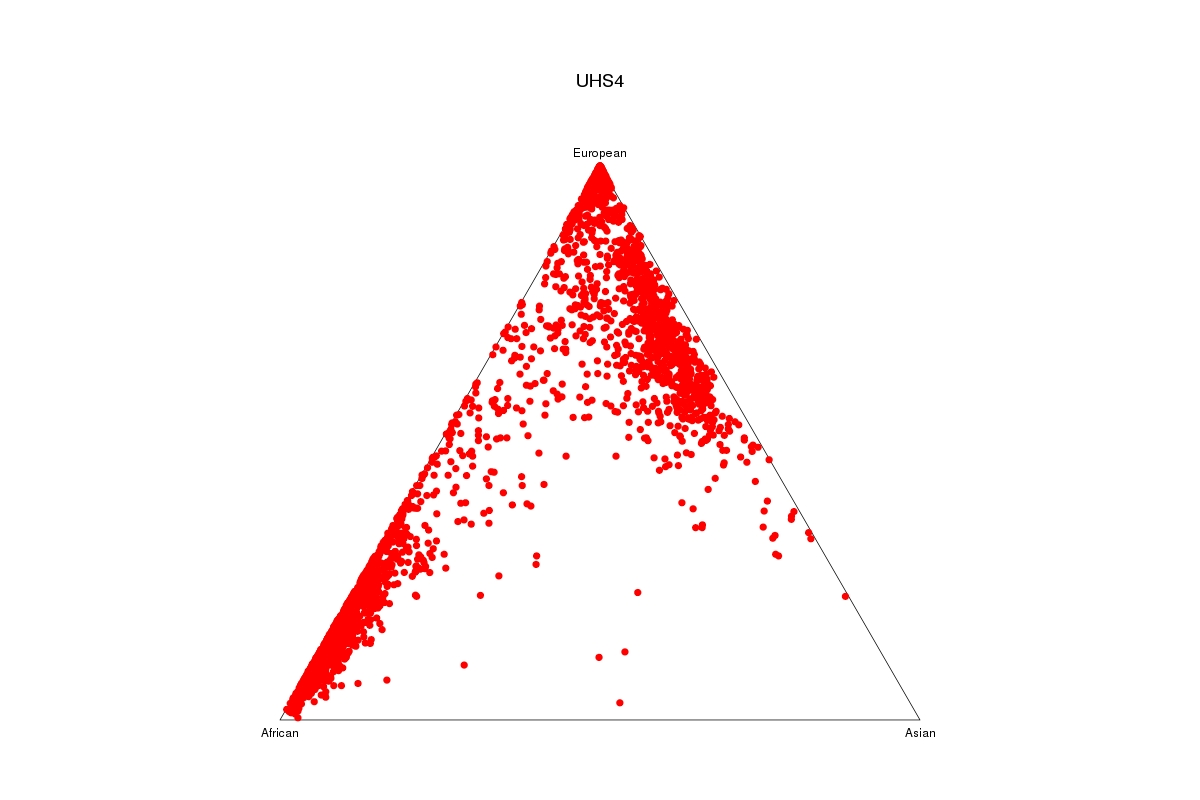

#### Reassigning and removing outliers
We are only concerned with the HA subjects for now.
The following retainment thresholds should be implemented:


| Action Description | Thresholding Criteria      |
|--------------------|----------------------------|
| For EA retainment | (AFR < 25%)$ \wedge $(EAS <= 25%) |
| For AA retainment | (AFR > 25%)$ \wedge $(EAS <= 25%) |

In [ ]:
## EC2 command line
### get details on which subjects are reassigned ###

#ha_thresh=0.08
plots=$baseD/structure/triangle_plots/filter

mkdir $plots
cp $baseD/structure/triangle_plots/afr_eas_eur.triangle_input $plots/
head -1 $baseD/structure/triangle_plots/afr_eas_eur.triangle_input > \
    $plots/afr_eas_eur_filtered.triangle_input

# AA retained
#================================================================================  
# Create triangle plot input with potential outliers filtered
eth=AA


tail -n +2 $plots/afr_eas_eur.triangle_input | \
    perl -lane 'if (($F[3] > 0.25 && $F[4] < 0.25)) { print $_ }' \
    > $plots/aa_filtered

# study=uhs4, for example
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}'  \
    $plots/aa_filtered >> $plots/afr_eas_eur_filtered.triangle_input


# EA retained
#================================================================================  
# Create triangle plot input with potential outliers filtered
eth=EA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -lane 'if (($F[3] < 0.25 && $F[4] < 0.25)) { print $_; }' \
    > $plots/ea_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' \
    $plots/ea_filtered >> $plots/afr_eas_eur_filtered.triangle_input
#================================================================================  

# HA retained
#================================================================================  
# Create triangle plot input with potential outliers filtered
#eth=HA
#
#
#tail -n +2 $plots/afr_eas_eur.triangle_input |\
#    perl -slane 'if (($F[3] < 0.25 && $F[4] >= $th)) { print $_; }' -- -th=$ha_thresh \
#    > $plots/ha_filtered
#awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' \
#    $plots/ha_filtered >> $plots/afr_eas_eur_filtered.triangle_input
--------------------------------------------------------------------------------

# subjects not assigned to any ancestry group
cat $plots/*filtered | sort > $plots/all.assigned
comm -13 $plots/all.assigned <(tail -n +2 $plots/../afr_eas_eur.triangle_input)  >\
    $plots/not.assigned
#head -1 $plots/afr_eas_eur_filtered.triangle_input > $plots/not.assigned.triangle_input 
#cat $plots/not.assigned >> $plots/not.assigned.triangle_input

_______________________________________________________________________________________________________________________________________________________
# Generate triangle plot
Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data $plots/afr_eas_eur_filtered.triangle_input \
    --prefix $plots/afr_eas_eur_filtered \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --xref $baseD/structure/triangle_plots/afr_eas_eur_id_xref


## Generate triangle plot for not assigned subjects
#Rscript /shared/bioinformatics/software/R/triangle_plot.R \
#    --data $plots/not.assigned.triangle_input \
#    --prefix $plots/not.assigned.afr_eas_eur \
#    --cluster1 African \
#    --cluster2 Asian \
#    --cluster3 European \
#    --xref $baseD/structure/triangle_plots/afr_eas_eur_id_xref

#### Filtered results
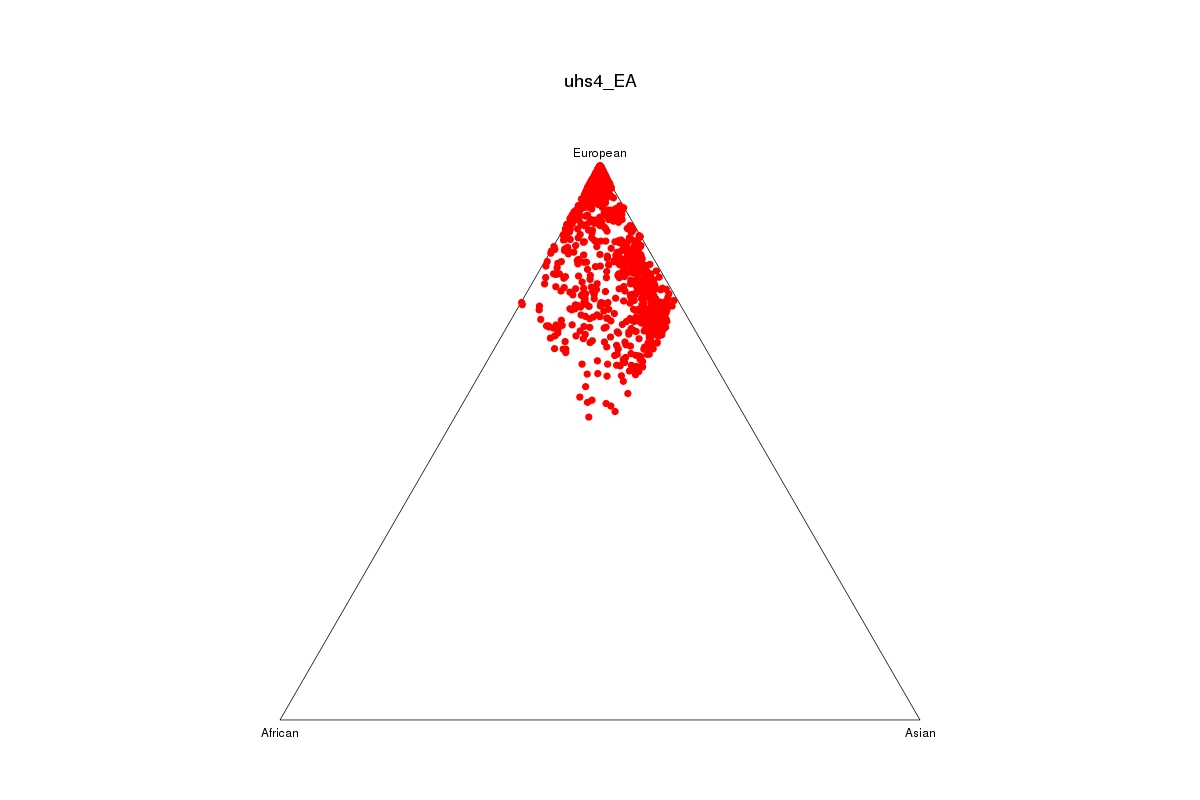
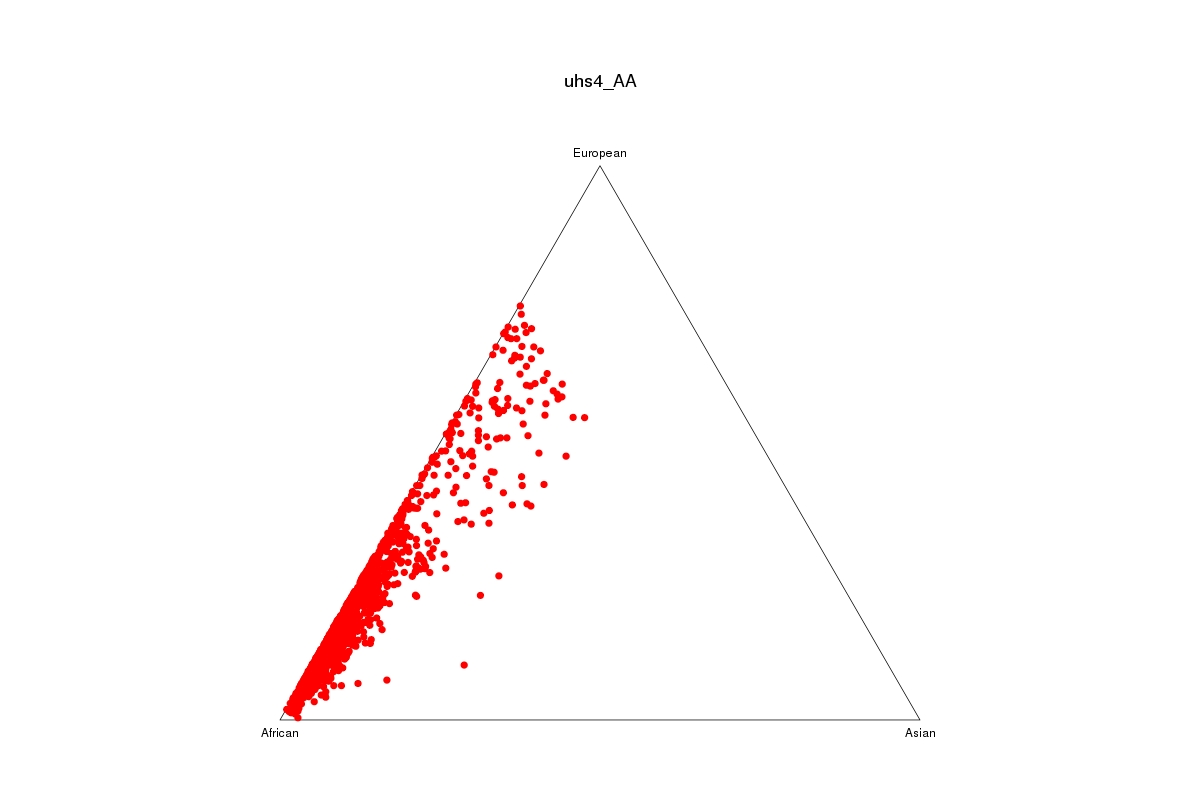

## Post-Structure
### Create updated PLINK filesets

In [ ]:
#anlist="ea aa"

# get ancestry counts after filtering + create a keepIDs list
for an in $anlist;do
    mkdir -p $baseD/$an/{autosomes,chrX}
    awk -v an="${an^^}" -v study="$study" '$3==study"_"an {print $2}' \
        $plots/afr_eas_eur_filtered_for_filtering.txt > $baseD/$an/subject_ids.keep
    wc -l $baseD/$an/subject_ids.keep
done
"""
1650 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/subject_ids.keep
1395 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/subject_ids.keep
"""

# split famID_IID up by tab --> famID"\t"IID
for an in $anlist;do
    while read line;do
        half=$(expr ${#line} / 2)
        echo ${line:0:$half} ${line:0:$half}
    done < $baseD/$an/subject_ids.keep > $baseD/$an/subject_ids.keep.txt
done
            
## subjects that were excluded
# create an informative file about subjects that were not
# included in any of the ancestry groups            
#clus1=AFR
#clus2=EAS
#clus3=EUR
#awk -v p1=$clus1 -v p2=$clus2 -v p3=$clus3 'NR==1 {
#    $4=$4"("p1")";
#    $5=$5"("p2 ")" ;
#    $6=$6"("p3 ")"} 
#    NR>=2 {
#    $2=substr($2,1, length($2) - (0.5 * length($2)) )}
#{print $0}' \
#            $plots/not.assigned.afr_eas_eur_for_filtering.txt >\
#            $plots/not.assigned.afr_eas_eur_for_filtering.cleaned.txt   

            
for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $procD/whole_genome/$study \
        --keep $baseD/${ancestry}/subject_ids.keep.txt \
        --make-bed \
        --out $baseD/${ancestry}/genotypes_b37_dbsnp138
done

for an in $anlist;do
    wc -l $baseD/$an/*{bim,fam}
done
"""
 2367429 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/genotypes_b37_dbsnp138.bim
    1650 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/genotypes_b37_dbsnp138.fam
    
 2367429 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/genotypes_b37_dbsnp138.bim
    1395 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/genotypes_b37_dbsnp138.fam
"""

In [ ]:
## EC2 command line

# Create autosome and chrX file sets
for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    mkdir $baseD/${ancestry}/{chrX,autosomes}

    # Autosomes
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $baseD/${ancestry}/genotypes_b37_dbsnp138 \
        --autosome \
        --make-bed \
        --out $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped

    # ChrX (include split PARs)
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $baseD/${ancestry}/genotypes_b37_dbsnp138 \
        --chr 23,25 \
        --make-bed \
        --out $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138_unmerged

    # Combine split chrX and PARs
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138_unmerged \
        --merge-x \
        --make-bed \
        --out $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138
done

## get counts
for an in $anlist;do
    wc -l $baseD/$an/{chrX,autosomes}/*.{bim,fam}
done
"""
   53349 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/chrX/genotypes_b37_dbsnp138.bim
   53349 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/chrX/genotypes_b37_dbsnp138_unmerged.bim
    1650 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/chrX/genotypes_b37_dbsnp138.fam
    1650 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/chrX/genotypes_b37_dbsnp138_unmerged.fam
 2311600 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_b37_dbsnp138_flipped.bim
    1650 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_b37_dbsnp138_flipped.fam
 2423248 total
   53349 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/chrX/genotypes_b37_dbsnp138.bim
   53349 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/chrX/genotypes_b37_dbsnp138_unmerged.bim
    1395 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/chrX/genotypes_b37_dbsnp138.fam
    1395 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/chrX/genotypes_b37_dbsnp138_unmerged.fam
 2311600 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_b37_dbsnp138_flipped.bim
    1395 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_b37_dbsnp138_flipped.fam
"""

### Genotype call rate variant filter
I calculate the genotype missing call rate and remove any variants with a rate >3%.

In [ ]:
# Get missing call rate
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 5000 \
        --bfile $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped \
        --geno $gcr \
        --make-bed \
        --out $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_filter
done

for an in $anlist;do
    wc -l $baseD/$an/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_filter*bim
done
"""
2064754 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_filter.bim
1895022 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_filter.bim
"""

### Hardy-Weinberg equilibrium filtering
Extensive deviation from Hardy-Weinberg equilibrium (HWE) can be indicative of a genotyping or genotype calling error. Using PLINK --hardy, I calculate goodness of fit test p-values for allele frequencies compared to HWE. Any variant with p < 0.0001 is removed.

In [ ]:
## EC2 command line

# Calculate HW p-values for each ancestry group
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_filter \
        --hwe $hwe \
        --make-bed \
        --out $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_${hwe}_filter
done

for an in $anlist;do
wc -l $baseD/$an/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter.*{bim,fam}
done
"""
 2019836 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter.bim
    1650 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter.fam
 2021486 total
 1642143 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter.bim
    1395 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter.fam
 """

### Genotype call rate subject filter
**Note**: The genotype call rate subject filtering and the subsequent LD pruning are specifically for relatedness filtering calculations. Autosomes and chrX merging will be done using the PLINK file sets generated in the preceding step (HWE filtering).

I calculate the genotype missing call rate and remove any subjects with a rate > $3\%$.

In [ ]:
## EC2 command line

# Remove variants
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_${hwe}_filter \
        --mind ${grc} \
        --make-bed \
        --out $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_${hwe}_subject_missing_lte_${gcr}_filter
done

for an in $anlist;do
echo $an
    wc -l $baseD/$an/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_lte_${gcr}_filter.{bim,fam,irem}
    echo ""
done
"""
ea
 2019836 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.bim
    1572 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.fam
      78 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.irem
 2021486 total

aa
 1642143 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.bim
    1246 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.fam
     149 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_lte_0.10_filter.irem
"""

### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are independent. This filtering will not carry forward to the final processed results, but this step improves the quality of identity-by-state (IBS) and identity-by-descent (IBD) calculations. Consequently, the LD pruned data will be used as input into IBS and IBD calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
## EC2 command line

# Run per chromosome LD pruning 
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix $baseD/${ancestry}/autosomes/${ancestry}_${chr}_ld_prune \
            --mem 7.5 \
            --priority 0 \
            --nslots 1 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --bfile $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_lte_${gcr}_filter \
                --indep-pairwise 50 5 0.5 \
                --chr ${chr} \
                --out $baseD/${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_chr${chr}
    done
done


for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    # Merge *prune.in files
    cat $baseD/${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_chr*.prune.in \
        > $baseD/${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_autosomes.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_lte_${gcr}_filter \
        --extract $baseD/${ancestry}/autosomes/genotypes_for_relatedness_filtering.ld_prune_autosomes.prune.in \
        --make-bed \
        --out $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter
done

for an in $anlist;do
    echo $an
    wc -l $baseD/$an/autosomes/genotypes_for_relatedness_ld_prune_filter.{bim,fam}
    echo 
done
"""
ea
  996866 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_for_relatedness_ld_prune_filter.bim
    1572 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_for_relatedness_ld_prune_filter.fam
  998438 total

aa
 1052271 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_for_relatedness_ld_prune_filter.bim
    1246 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_for_relatedness_ld_prune_filter.fam"""

### Identical-by-state and identical-by-descent filtering
Identical-by-state or identity-by-state (IBS) filtering provides a means to identify duplicate subjects or monozygotic twins. Identical-by-descent or identity-by-descent allows for detection of high relatedness. For computational efficiency and memory usage limitations, ibd_pipeline.v4.sh is used to perform IBS/IBD calculations on data chunks that are used as input for IBS and IBD filtering. If the study contains AA subjects, then for AA subjects only, [KING](http://people.virginia.edu/~wc9c/KING/manual.html) is used as an additional relationship inference tool for filtering.

For these filtering steps, a list of individuals is identified separately for each filtering type then combined into a final list for exclusion. Following IBS filtering, if any individuals are identified for removal, a graph analysis needs to be done to account for an individual being related/identical to multiple individuals. Removal criteria is based on genotype calling rate. These individuals would need to be removed before running IBD filtering and KING. Graph analysis would need to be run after IBD calculations/KING if individuals were selected for removal.

In [ ]:
## EC2 command line

# Calculate allele frequencies in data chunks
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/scripts/ibd_pipeline.sh \
        --in_prefix $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter \
        --out_dir $baseD/${ancestry}/autosomes/
    sleep 5s
done


# Aggregate data
for ancestry in $anlist; do
    outfile=$baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter.genome
    head -1 `ls $baseD/${ancestry}/autosomes/data.sub.genome* | head -1` > ${outfile}
    cat $baseD/${ancestry}/autosomes/data.sub.genome* | \
        grep -v FID1 >> ${outfile}

    # Remove temporary files
    rm $baseD/${ancestry}/autosomes/data.sub.*
    rm $baseD/${ancestry}/autosomes/tmp_sh*.sh
done

### IBS filtering
For individual pairs with greater than 0.9 IBS score, only the individual with the lower genotype missing call rate is retained. I create a list of individuals to remove that will be combined with the IBD list for final filtering but removed from the LD pruned data before running IBD filtering.

In [ ]:
## EC2 command line

# Calculate missingness
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter \
        --missing \
        --out $baseD/${ancestry}/autosomes/autosome_missing_call_rate
done

# Get list of individuals with IBS > 0.9
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    Rscript /shared/bioinformatics/software/R/merge_genome_missing.R \
        --genome $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter.genome \
        --imiss $baseD/${ancestry}/autosomes/autosome_missing_call_rate.imiss \
        --type IBS \
        --out $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter
done


"""
================ ea ================


[1] "Reading genome file /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_for_relatedness_ld_prune_filter.genome"
[1] "Reading missing file /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBS"
[1] "281234 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"


================ aa ================


[1] "Reading genome file /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_for_relatedness_ld_prune_filter.genome"
[1] "Reading missing file /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBS"
[1] "129 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"
"""

#### Graph Analysis for IBS
In graph analysis a network of related individuals is created. Genotype call rate is calculated within this network to determine which individuals to remove. The purpose of using a network-based filtering is to prevent too many individuals from being unnecessarily removed when relationships extend beyond pairwise relatedness.

In [ ]:
# R console #
# Graph analysis to determine minimum # of subjects to remove
R
library(igraph)
setwd("/shared/data/studies/heroin/uhs4/genotype/observed/processing/004")
for(ancestry in c("ea", "aa")){
    stats = read.table(paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.stats"), header = TRUE, colClasses="character")
    ibdPairs = as.data.frame(cbind(paste(stats$FID2, stats$IID2, sep="__"), paste(stats$FID1, stats$IID1, sep="__")), stringsAsFactors = FALSE)
    colnames(ibdPairs) = c("fid_iid_1","fid_iid_2")
    ibdGraph = graph.data.frame(ibdPairs, directed = FALSE)
    vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    removeList = vector()
    while (length(vertexDegrees) > 0 && vertexDegrees[1] > 1) {
        if (exists("removeList")) {
            removeList = c(removeList, names(vertexDegrees[1]))
        } else {
            removeList = names(vertexDegrees[1])
        }
        ibdGraph = ibdGraph - names(vertexDegrees[1])
        vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    }
    ibdPairs = ibdPairs[!(ibdPairs[,1] %in% removeList) & !(ibdPairs[,2] %in% removeList),]
    imiss = read.table(paste0(ancestry, "/autosomes/autosome_missing_call_rate.imiss"), header = TRUE, colClasses = "character")
    imiss = as.data.frame(cbind(paste(imiss$FID, imiss$IID, sep="__"), as.numeric(imiss$F_MISS)), stringsAsFactors = FALSE)
    colnames(imiss) = c("fid_iid_1","f_miss_1")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_1", sort = FALSE)
    colnames(imiss) = c("fid_iid_2","f_miss_2")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_2", sort = FALSE)
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] < ibdPairs["f_miss_2"],"fid_iid_2"])
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] >= ibdPairs["f_miss_2"],"fid_iid_1"])
    removeList = cbind(lapply(strsplit(removeList,"__"), function(x) x[1]),lapply(strsplit(removeList,"__"), function(x) x[2]))
    write.table(removeList, file=paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove"), row.names = FALSE, col.names = FALSE, quote = FALSE)
    rm(removeList)
}

#### Remove IBS problematic subjects
Before proceeding with IBD filtering, the problematic subjects need to be removed.

In [ ]:
## EC2 command line

# Make new PLINK file set
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_filter \
        --remove $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove \
        --make-bed \
        --out $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter
done

for an in $anlist;do
    wc -l $baseD/$an/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam
done
"""
686 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam
1130 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.fam
"""


# Calculate allele frequencies in data chunks
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/scripts/ibd_pipeline.sh \
        --in_prefix $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter \
        --out_dir $baseD/${ancestry}/autosomes/
    sleep 5s
done

# Aggregate data
for ancestry in $anlist; do
    outfile=$baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome
    head -1 `ls $baseD/${ancestry}/autosomes/data.sub.genome* | head -1` > ${outfile}
    cat $baseD/${ancestry}/autosomes/data.sub.genome* | \
        grep -v FID1 >> ${outfile}

    # Remove temporary files
    rm $baseD/${ancestry}/autosomes/data.sub.*
    rm $baseD/${ancestry}/autosomes/tmp_sh*.sh
done

### IBD filtering
For individual pairs with greater than 0.4 IBD score, only the individual with the lower genotype missing call rate is retained. I create a list of individuals to remove that will be combined with the IBS list.

In [ ]:
## EC2 command line

# Get list of individuals with IBD > 0.4
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    Rscript /shared/bioinformatics/software/R/merge_genome_missing.R \
        --genome $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome \
        --imiss $baseD/${ancestry}/autosomes/autosome_missing_call_rate.imiss \
        --type IBD \
        --pi_hat_threshold 0.4 \
        --out $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter
done

"""
================ ea ================


[1] "Reading genome file /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome"
[1] "Reading missing file /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBD > 0.4"
[1] "0 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"


================ aa ================


[1] "Reading genome file /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome"
[1] "Reading missing file /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/autosome_missing_call_rate.imiss"
[1] "Filtering"
[1] "IBD > 0.4"
[1] "0 rows meet filtering criteria"
[1] "Merging files"
[1] "Printing output"
"""

**Note:** No subjects are problematic.

### Relationship inference using KING
For subjects with African ancestry, KING provides a better estimation of relatedness. I use this software to further identify subjects for removal.

In [ ]:
#### EC2 command line
#
## Run KING
#/shared/bioinformatics/software/third_party/king_v2.1.2/king \
#    -b $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.bed \
#    --kinship \
#    --cpus 1 \
#    --prefix $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king
#
## Extract PLINK IBD calculations for subject pairs
#outFile=$procD/aa/autosomes/genotypes_for_relatedness.genome_lite
#echo -e "PAIR_ID\tPI_HAT" > $outFile
#tail -n +2 $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome | \
#    perl -lane '$pairId = "";
#        if ($F[0] < $F[2] || ($F[0] == $F[2] && $F[1] < $F[3])) {
#            $pairId = join("_",$F[0],$F[1],$F[2],$F[3]);
#        } else {
#            $pairId = join("_",$F[2],$F[3],$F[0],$F[1]);
#        }
#        print $pairId."\t".$F[9];' >> $outFile
#
## Extract KING kinship calculations for subject pairs
#outFile=$procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.king_lite
#echo -e "PAIR_ID\tKINSHIP" > $outFile
#tail -n +2 $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.kin | \
#
#    perl -lane '$pairId = "";
#        if ($F[0] < $F[2] || ($F[0] == $F[2] && $F[1] < $F[3])) {
#            $pairId = join("_",$F[0],$F[1],$F[2],$F[3]);
#        } else {
#            $pairId = join("_",$F[2],$F[3],$F[0],$F[1]);
#        }
#        print $pairId."\t".$F[7];' >> $outFile
#
#tail -n +2 $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.kin | \
#    perl -lane '$pairId = "";
#        if ($F[1] < $F[2]) {
#            $pairId = join("_",$F[0],$F[1],$F[0],$F[2]);
#        } else {
#            $pairId = join("_",$F[0],$F[2],$F[0],$F[1]);
#        }
#        print $pairId."\t".$F[8];' >> $outFile
#
## Combine IBD and kinship results
#Rscript /shared/bioinformatics/software/R/merge_datasets.R \
#    --in_1 $procD/aa/autosomes/genotypes_for_relatedness.genome_lite \
#    --in_1_column PAIR_ID \
#    --in_1_header \
#    --in_2 $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.king.king_lite \
#    --in_2_column PAIR_ID \
#    --in_2_header \
#    --out $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome+king \
#    --out_header
#
## Identify discrepancies between PLINK IBD and KING kinship values
#perl -lane 'if ($F[2] > 0.177 && $F[1] > 0.4) { print "AGREE\t".$_; } elsif ($F[2] > 0.177 || $F[1] > 0.4) { print "DISAGREE\t".$_; }' $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome+king \
#    > $procD/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_filter.genome+king.ibd_comparison

#### Graph Analysis for IBD
In graph analysis a network of related individuals is created. Genotype call rate is calculated within this network to determine which individuals to remove. The purpose of using a network-based filtering is to prevent too many individuals from being unnecessarily removed when relationships extend beyond pairwise relatedness.

**Note** for this case, no subjects were listed for removal during the ibd analysis. Therefore, we do not need to run graph analysis.

In [ ]:
## EC2 command line

# Get genotype missing call rate for graph analysis
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_lte_${gcr}_filter \
        --missing \
        --out $baseD/${ancestry}/autosomes/genotypes_for_relatedness
done

In [ ]:
# R console #
# Graph analysis to determine minimum # of subjects to remove
R
library(igraph)
setwd("/shared/data/studies/heroin/uhs4/genotype/observed/processing/004")
for(ancestry in c("ea", "aa")){
    stats = read.table(paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_filter.stats"), header = TRUE, colClasses="character")
    ibdPairs = as.data.frame(cbind(paste(stats$FID2, stats$IID2, sep="__"), paste(stats$FID1, stats$IID1, sep="__")), stringsAsFactors = FALSE)
    colnames(ibdPairs) = c("fid_iid_1","fid_iid_2")
    ibdGraph = graph.data.frame(ibdPairs, directed = FALSE)
    vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    removeList = vector()
    while (length(vertexDegrees) > 0 && vertexDegrees[1] > 1) {
        if (exists("removeList")) {
            removeList = c(removeList, names(vertexDegrees[1]))
        } else {
            removeList = names(vertexDegrees[1])
        }
        ibdGraph = ibdGraph - names(vertexDegrees[1])
        vertexDegrees = sort(degree(ibdGraph), decreasing = TRUE)
    }
    ibdPairs = ibdPairs[!(ibdPairs[,1] %in% removeList) & !(ibdPairs[,2] %in% removeList),]
    imiss = read.table(paste0(ancestry, "/autosomes/autosome_missing_call_rate.imiss"), header = TRUE, colClasses = "character")
    imiss = as.data.frame(cbind(paste(imiss$FID, imiss$IID, sep="__"), as.numeric(imiss$F_MISS)), stringsAsFactors = FALSE)
    colnames(imiss) = c("fid_iid_1","f_miss_1")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_1", sort = FALSE)
    colnames(imiss) = c("fid_iid_2","f_miss_2")
    ibdPairs = merge(ibdPairs, imiss, by="fid_iid_2", sort = FALSE)
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] < ibdPairs["f_miss_2"],"fid_iid_2"])
    removeList = c(removeList, ibdPairs[ibdPairs["f_miss_1"] >= ibdPairs["f_miss_2"],"fid_iid_1"])
    removeList = cbind(lapply(strsplit(removeList,"__"), function(x) x[1]),lapply(strsplit(removeList,"__"), function(x) x[2]))
    write.table(removeList, file=paste0(ancestry, "/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove"), row.names = FALSE, col.names = FALSE, quote = FALSE)
    rm(removeList)
}

### Constructing relatedness filtering lists
The output of the IBS filtering and the IBD filtering are combined into a single remove list.

**Note** that there were no IBD individuals, but we will keep the naming convention for convenience of using legacy code through the pipeline.

In [ ]:
## EC2 command line

# Get list of individuals from IBD and IBS filter lists
for ancestry in $anlist;do
    cat $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibd_gt_0.4_igraph.remove \
        $baseD/${ancestry}/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove | \
        sort -u > $baseD/${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
done

for an in $anlist;do
    echo $an
    wc -l $baseD/$an/autosomes/*remove
    echo
done
"""
   886 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove
   886 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove

aa
  116 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/genotypes_for_relatedness_ld_prune_ibs_gt_0.9_igraph.remove
  116 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
"""

The list of subjects in this `*remove` file will be retained as a filtering list for the merged autosome and chrX PLINK file sets. This list includes subjects that were indicated for removal by both `ibs` and `ibd` filtering steps.

### ChrX Processing 
#### Missing data subject filtering
We calculate the proportion of missing genotype calls on chrX using PLINK to assess whether any subjects have data missing for the whole chromosome.

In [ ]:
## EC2 command line

# Get missing call rate for chrX
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138 \
            --missing \
            --chr 23 \
            --out $baseD/${ancestry}/chrX/chrX_missing_call_rate
done

for ancestry in $anlist;do
    # Find subjects that have data missing for whole chrX
    tail -n +2 $baseD/${ancestry}/chrX/chrX_missing_call_rate.imiss | \
        awk '{ OFS="\t" } { if($6==1){ print $1,$2 } }' >> $baseD/${ancestry}/chrX/missing_whole_chrX.remove
    echo -e "\nNumber of ${ancestry} subjects with missing whole chromosome: $(wc -l $baseD/${ancestry}/chrX/missing_whole_chrX.remove)\n"
done

"""
Number of ea subjects with missing whole chromosome: 0 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/chrX/missing_whole_chrX.remove
Number of aa subjects with missing whole chromosome: 0 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/chrX/missing_whole_chrX.remove

"""

**Note:** If subjects ever show up as having missing data then further discussions need to be had on whether these subjects should be removed completely or whether they should only be excluded for the missing chromosome.

In [ ]:
##EC2 command line ##
for an in $anlist;do
    rm $baseD/$an/chrX/chr*missing_call_rate*
done

#### Remove duplicate SNPs

If multiple rsIDs are present then the one with the better genotype call rate across subjects should be retained. Obtaining the genotype call rates across subjects would need to be calculated using PLINK --missing.

In [ ]:
## EC2 command line

# Find duplicate rsIDs
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    cut -f2,2 $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138.bim | \
    sort | \
    uniq -D \
    > $baseD/${ancestry}/chrX/snp_duplicates.txt
    echo -e "\n\nNumber of ${ancestry} variant duplicates: $(wc -l $baseD/${ancestry}/chrX/snp_duplicates.txt)\n\n"
done

For this case, there are no duplicated rsIDs.

#### Strand flipping
If strand flipping was an issue for the autosomes, it would also be an issue for chrX. 

In [ ]:
chr=23

# Extract unflipped variants
for ancestry in $anlist; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr} \
        --script_prefix $baseD/${ancestry}/chrX/chr${chr}_flip_tests \
        --mem 6 \
        --priority 0 \
        --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 6000 \
            --bfile $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138 \
            --chr ${chr} \
            --make-bed \
            --out $baseD/${ancestry}/chr${chr}_unflipped
done


# Attempt merge with 1000G data
for ancestry in $anlist; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr} \
        --script_prefix $baseD/${ancestry}/chrX/chr${chr}_flip_tests \
        --mem 6 \
        --priority 0 \
        --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 6000 \
            --bfile $baseD/${ancestry}/chr${chr}_unflipped \
            --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX \
            --merge-mode 7 \
            --out $baseD/${ancestry}/chr${chr}_unflipped_test
done

# Flip problematic variants
for ancestry in $anlist; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix $baseD/${ancestry}/chrX/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138 \
                --chr ${chr} \
                --flip $baseD/${ancestry}/chr${chr}_unflipped_test.missnp \
                --make-bed \
                --out $baseD/${ancestry}/chr${chr}_flipped
done

# Attempt merge with 1000G data
for ancestry in $anlist; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr} \
            --script_prefix $baseD/${ancestry}/chrX/chr${chr}_flip_tests \
            --mem 6 \
            --priority 0 \
            --program  /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 6000 \
                --bfile $baseD/${ancestry}/chr${chr}_flipped \
                --bmerge /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX \
                --merge-mode 7 \
                --out $baseD/${ancestry}/chr${chr}_flipped_test
done

# Combine flip lists
for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    cat $baseD/${ancestry}/chr*_unflipped_test.missnp | sort -u > $baseD/${ancestry}/chr_all_unflipped_test.missnp
    cat $baseD/${ancestry}/chr*_flipped_test.missnp | sort -u > $baseD/${ancestry}/chr_all_flipped_test.missnp
    comm -23 $baseD/${ancestry}/chr_all_unflipped_test.missnp $baseD/${ancestry}/chr_all_flipped_test.missnp \
        > $baseD/${ancestry}/chrX/chr_all.flip
    
    # Perform final flip
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138 \
        --flip $baseD/${ancestry}/chrX/chr_all.flip \
        --exclude $baseD/${ancestry}/chr_all_flipped_test.missnp \
        --make-bed \
        --out $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138_flipped
done

# Clean up
for an in $anlist;do
    rm $baseD/$an/chr*flipped*
    rm $baseD/$an/chrX/chr*flip*
    wc -l $baseD/$an/chrX/genotypes_b37_dbsnp138_flipped.bim
    wc -l $baseD/$an/chrX/genotypes_b37_dbsnp138_flipped.fam
done

#### Genotype call rate variant filter

I calculate the genotype missing call rate and remove any variants with a rate $> 3\%$.

**Note** we are using 10% in this case for the UHS data.

In [ ]:
## EC2 command line

# Get missing call rate
# note that I added the "subject_missing_chrx" filter at the end just for 
# convenience even though no subjects were filtered during that stage
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138_flipped \
        --geno ${gcr} \
        --make-bed \
        --out $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_filter_subject_missing_chrx
done

for ancestry in $anlist;do
    echo $ancestry
    wc -l $baseD/$ancestry/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_filter_subject_missing_chrx.{bim,fam}
    echo 
done
"""
ea
  37301 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_filter_subject_missing_chrx.bim
   1650 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_filter_subject_missing_chrx.fam

aa
  30934 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_filter_subject_missing_chrx.bim
   1395 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_filter_subject_missing_chrx.fam
"""

#### Hardy-Weinberg equilibrium filtering
The Hardy-Weinberg Theorem (or Law) characterizes the distributions of genotype frequencies. It is basically the null model for population genetics. Tests for Hardy-Weinberg genotype frequencies are used primarily to test for population stratification and other forms of non-random mating. Extensive deviation from Hardy-Weinberg equilibrium (HWE) can be indicative of a genotyping or genotype calling error. Using PLINK `--hardy`, I calculate goodness of fit test p-values for allele frequencies compared to HWE. Any variant with p < 0.0001 is removed.

See [nature webpage](https://www.nature.com/scitable/knowledge/library/the-hardy-weinberg-principle-13235724) which describes more about HWE.

In [ ]:
## EC2 command line

# Calculate HW p-values for each ancestry group
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --memory 3800 \
        --noweb \
        --bfile $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_filter_subject_missing_chrx \
        --hwe 0.0001 \
        --make-bed \
        --out $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter_subject_missing_chrx
    
done
for ancestry in $anlist; do
    echo $ancestry 
    wc -l $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter_subject_missing_chrx.{bim,fam}
    echo 
done

"""
ea
  36562 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter_subject_missing_chrx.bim
   1650 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter_subject_missing_chrx.fam

aa
 27579 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter_subject_missing_chrx.bim
  1395 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_filter_subject_missing_chrx.fam
"""

### Merge autosomes and chrX
The data processed through to HWE filtering for both the autosomes and chrX are merged before applying the final subject filtering steps.

In [ ]:
## EC2 command line

# note that for convenience, we include in the title "subject missing_chrx_filter" 
# even though no subjects were filtered during that step.
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $baseD/${ancestry}/autosomes/genotypes_b37_dbsnp138_flipped_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter \
        --bmerge $baseD/${ancestry}/chrX/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_filter_subject_missing_chrx \
        --make-bed \
        --out $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr
    
done

for ancestry in $anlist; do
    echo $ancestry
    wc -l $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr.{bim,fam}
    echo
done
"""
 2056398 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr.bim
    1650 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr.fam
 2058048 total

aa
 1669722 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr.bim
    1395 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr.fam
"""

### Relatedness filter
From relatedness calculations on the autosomal data, I remove subjects that are closely related or seemingly identical.

In [ ]:
## EC2 command line

# Remove variants
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_filter.all_chr \
        --remove $baseD/${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove \
        --make-bed \
        --out $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_filter.all_chr
done

for ancestry in $anlist; do
    echo -e "\nNumber of ${ancestry} subjects removed: $(wc -l  $baseD/${ancestry}/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove)\n"
    echo
done

"""
Number of ea subjects removed: 886 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove

Number of aa subjects removed: 116 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/autosomes/ibs_gt_0.9_ibd_gt_0.4.remove
"""

### Genotype call rate subject filter

I calculate the genotype missing call rate and remove any subjects with a rate $> 3\%$.

**Note** we are using 10% in this case for the UHS data.

In [ ]:
## EC2 command line

# Remove variants
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_filter.all_chr \
        --mind ${gcr} \
        --make-bed \
        --out $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_filter.all_chr
done

for ancestry in $anlist; do
    echo $ancestry
    wc -l $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_filter.all_chr.fam
    echo 
done
"""
ea
685 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_filter.all_chr.fam

aa
1130 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_filter.all_chr.fam
"""

### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of sex check and excessive homozygosity calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
## EC2 command line

# Run per chromosome LD pruning for each chr
for ancestry in $anlist; do
    for chr in {1..23}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix $baseD/${ancestry}/${ancestry}_${chr}_ld_prune \
            --mem 7.5 \
            --nslots 1 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --bfile $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_filter.all_chr \
                --indep-pairwise 50 5 0.5 \
                --chr ${chr} \
                --out $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr${chr}_filter
    done
done

# Merge *prune.in files
for ancestry in $anlist; do
    cat $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr*_filter.prune.in \
        > $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_filter.all_chr \
        --extract $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter.prune.in \
        --make-bed \
        --out $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter
done

for ancestry in $anlist; do
    echo $ancestry
    wc -l $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter.{fam,bim}
    echo
done
"""
ea
     685 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_ld_prune_chr_all_filter.fam
  970801 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_ld_prune_chr_all_filter.bim

aa
    1130 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_ld_prune_chr_all_filter.fam
 1067865 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_ld_prune_chr_all_filter.bim
 """

### Sex Check
To verify that self-reported gender status matches with the genetic information, I use PLINK `--split-x` followed by `--check-sex` to confirm the data agree. Our discrepancy criteria are

* Reported as male (coded as 1) but F < 0.2
* Reported as female (coded as 2) but F > 0.8

In [ ]:
## EC2 command line

# Break out the pseudo-autosomal region on chrX (will be stored as chr 25)
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter \
        --split-x b37 \
        --make-bed \
        --out $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr

    # Run sex check
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr \
        --check-sex \
        --out $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr

    # Get subjects that do not meet inbreeding coefficient thresholds
    perl -lane 'if ($F[2]==1 && $F[5]<0.2) { print $_; } elsif ($F[2]==2 && $F[5]>0.8) { print $F[0]."\t".$F[1]; }' $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck \
        > $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck.threshold_fail

    # Get subjects that are problematic due to no inbreeding coefficient value
    perl -lane 'if ($F[4] eq "PROBLEM" && $F[5] eq "nan") { print $F[0]."\t".$F[1]; }' $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck \
        > $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck.nan_fail

    # Combine discordant subjects into one remove list
    cat $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck.*_fail | \
        sort -u \
        > $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck.remove

done

for ancestry in $anlist; do
    echo $ancestry
    wc -l $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_split_chrX_filter.all_chr.sexcheck.remove
    echo 
done    
    
# Print number of discrepancies
"""
ea
0 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/ea/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_ld_prune_split_chrX_filter.all_chr.sexcheck.remove

aa
0 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/aa/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.10_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.10_ld_prune_split_chrX_filter.all_chr.sexcheck.remove

"""

For these data the sex check yielded **0 discrepancies**  If any individuals failed the check then they would be removed before subsequent steps using the file set generated after gentoype call rate subject filtering (before removing the pseudo-autosomal chrX region).

### Excessive homozygosity filter
Excessive homozygosity checks for inbreeding and population substructure. This check is implemented using PLINK. According to their documentation, the statistics used for this filtering are not LD-sensitive, i.e., an LD pruned dataset is recommended as input. Additionally, the documentation states that only autosomal data are used, so concerns of chrX biasing results are irrelevant.

In [ ]:
## EC2 command line

# Get homozygosity stats
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter \
        --het \
        --out $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter

   # Identify problematic subjects
    perl -lane 'if ($F[5] < -0.2 || $F[5] > 0.5) { print $F[0]." ".$F[1]; }' $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_chr_all_filter.het \
    > $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_homozygosity_check_chr_all_filter.remove

    # Remove problematic subjects
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_filter.all_chr \
        --remove $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_ld_prune_homozygosity_check_chr_all_filter.remove \
        --make-bed \
        --out $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_failed_sex_check_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_homozygosity_check_filter.all_chr

    echo -e "\nNumber of ${ancestry} subjects removed: $(wc -l  $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_0.03_hwe_p_gte_0.0001_subject_missing_chrx_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_0.03_ld_prune_homozygosity_check_chr_all_filter.remove)\n\n"
done

No subjects to remove, in this case. 

### Recoding variants for 1000G phase 3
RefSeq IDs (rsIDs) for variants can vary depending on the dbSNP build used and variant IDs do not all use RefSeq nomenclature. To provide a common nomenclature that will make comparisons across data sets feasible, I use a script that recodes all variant names to match 1000G phase 3 variants by position and alleles. The 1000G Phase 3 data I used for STRUCTURE are from /shared/data/ref_panels/1000G/2013.05/plink on AWS EC2, but /shared/data/ref_panels/1000G/2014.10/ also contains 1000G Phase 3 data derived from the May 2013 release. The difference is that it was downloaded from the IMPUTE2 website and reformatted to be directly compatible with IMPUTE2.

The data in `/shared/data/ref_panels/1000G/2014.10/` is used for variant name recoding, but the 1000G genotype information is acquired from `/shared/data/ref_panels/1000G/2013.05/plink`.

In [ ]:
## EC2 command line

mkdir $baseD/1000g_name_recoding

for ancestry in $anlist; do
    for ext in {bed,bim,fam}; do
        cp  $baseD/${ancestry}/genotypes_b37_dbsnp138_structure_variant_missing_lte_${gcr}_hwe_p_gte_0.0001_subject_missing_chrx_failed_sex_check_ibs_gt_0.9_ibd_gt_0.4_subject_missing_lte_${gcr}_homozygosity_check_filter.all_chr.${ext} \
            $baseD/1000g_name_recoding/${ancestry}_chr_all.${ext}
    done
done

wc -l $baseD/1000g_name_recoding/*{bim,fam}
"""
  1669722 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all.bim
  2056398 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all.bim
     1130 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all.fam
      685 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all.fam
"""

#### Variant ID updating
Because the 1000G data and the study data have RefSeq IDs (rsIDs) from different dbSNP builds, I standardize them using convert_to_1000g_ids.pl. In the study data set, certain indels may be represented as two variants, a monomorphic variant and an indel with the - symbol for one of the alleles. For example:

```
1   rs201826967  0.809   57873968   0   G
1   rs11284630   0.809   57873969   -   A
```

These two variants represent a G:GA indel and is coded as such in the 1000 Genomes data. The script to update the names to 1000 Genomes IMPUTE2 format will assign the same ID to these two variants. The duplicated IDs will cause problems for PLINK filtering, so I will remove the variant from a set of duplicate IDs that has the lower genotype call rate. Duplicates may arise for other reasons, and they will be filtered based on the same criterion.

In [ ]:
## EC2 command line
thouN=$baseD/1000g_name_recoding

mkdir $thouN/1000g_data

# Break out data by chr
for ancestry in $anlist; do
    for chr in {1..23}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 2048 \
            --bfile $thouN/${ancestry}_chr_all \
            --chr ${chr} \
            --make-bed \
            --out $thouN/${ancestry}_chr${chr}
    done
done


# Rename study autosome variant IDs
for ancestry in $anlist; do
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name recode.study.to.1000g.${chr} \
            --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
            --mem 6 \
            --nslots 1 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
                --file_in $thouN/${ancestry}_chr${chr}.bim \
                --file_out $thouN/${ancestry}_chr${chr}_renamed.bim \
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
                --file_in_header 0 \
                --file_in_id_col 1 \
                --file_in_chr_col 0 \
                --file_in_pos_col 3 \
                --file_in_a1_col 4 \
                --file_in_a2_col 5 \
                --chr ${chr}
    done
done


# Rename study chrX variant IDs
chr=23
for ancestry in $anlist; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode.study.to.1000g.${chr} \
        --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
        --mem 6 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in $thouN/${ancestry}_chr${chr}.bim \
            --file_out $thouN/${ancestry}_chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done


# Rename 1000G autosome variant IDs
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode.1KG.to.1000g.${chr} \
        --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
        --mem 8 \
        --nslots 1 \
        --priority 0 \
        --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.bim \
            --file_out $thouN/1000g_data/chr${chr}_renamed.bim \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 0 \
            --file_in_id_col 1 \
            --file_in_chr_col 0 \
            --file_in_pos_col 3 \
            --file_in_a1_col 4 \
            --file_in_a2_col 5 \
            --chr ${chr}
done


# Rename 1000G chrX variant IDs
chr=23
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name recode.1KG.to.1000g.${chr} \
    --script_prefix $thouN/${ancestry}_chr${chr}_id_rename \
    --mem 8 \
    --priority 0 \
    --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chrX.bim \
        --file_out $thouN/1000g_data/chr${chr}_renamed.bim \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --file_in_header 0 \
        --file_in_id_col 1 \
        --file_in_chr_col 0 \
        --file_in_pos_col 3 \
        --file_in_a1_col 4 \
        --file_in_a2_col 5 \
            --chr ${chr}

#### Remove duplicate variant ID
Many of the functions in PLINK will throw errors when duplicate variant IDs are found.To resolve this, duplicate variant IDs are identified, and only the duplicate variant with the best genotype call rate is retained.

In [ ]:
## EC2 command line

for ancestry in $anlist; do
    for chr in {1..23}; do
        echo -e "\n ==== ${ancestry} - chr${chr} ==== \n"
        # Append _X (where X is a number) to the end of the variant IDs for all but 1st occurrence of duplicates
        perl -lane 'BEGIN { %idCounts = (); }
                    if (exists($idCounts{$F[1]})) {
                        $idCounts{$F[1]}++;
                        print join("\t",$F[0],$F[1]."_".$idCounts{$F[1]},$F[2],$F[3],$F[4],$F[5]);
                    } else {
                        $idCounts{$F[1]} = 1;
                        print;
                    }' $thouN/${ancestry}_chr${chr}_renamed.bim > \
            $thouN/${ancestry}_chr${chr}_renamed_dups.bim

        # Generate list of duplicate SNPs
        grep -P "_[1-9]" $thouN/${ancestry}_chr${chr}_renamed_dups.bim |
            perl -lane 'print substr($F[1], 0, index($F[1],"_"))."\n".$F[1];' > \
            $thouN/${ancestry}_chr${chr}_renamed_dups.dupvar_list
    done
done

# see if there were any duplicates
count_fun () { echo $(wc -l $thouN/$1*dupvar_list | tail -1); }

# Get call rates for duplicate SNPs
for ancestry in $anlist; do

    counter=$(count_fun $ancestry)
    if [ "$counter" != "0 total" ]; then
    
        for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] != 0) { $F[1] =~ /chr(\d+)/; print $1; }'); do
            /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 2048 \
                --bed $thouN/${ancestry}_chr${chr}.bed \
                --bim $thouN/${ancestry}_chr${chr}_renamed_dups.bim \
                --fam $thouN/${ancestry}_chr${chr}.fam \
                --extract $thouN/${ancestry}_chr${chr}_renamed_dups.dupvar_list \
                --allow-no-vars \
                --missing \
                --out $thouN/${ancestry}_chr${chr}_renamed_dups

            # Create remove list that contains the duplicate with the higher missing rate
            tail -n +2 $thouN/${ancestry}_chr${chr}_renamed_dups.lmiss | \
                perl -lane 'BEGIN { %missingness = (); }
                            if ($F[1] =~ /^(\S+)\_/) {
                                $duplicateName = $1
                            } else {
                                $duplicateName = $F[1]."_2";
                            }
                            if (exists($missingness{$duplicateName})) {
                                if ($missingness{$duplicateName} > $F[4]) {
                                    print $duplicateName;
                                } else {
                                    print $F[1];
                                }
                            } else {
                                $missingness{$F[1]} = $F[4];
                            }' \
                    > $thouN/${ancestry}_chr${chr}_renamed_dups.remove

            /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 2048 \
                --bed $thouN/${ancestry}_chr${chr}.bed \
                --bim $thouN/${ancestry}_chr${chr}_renamed_dups.bim \
                --fam $thouN/${ancestry}_chr${chr}.fam \
                --exclude $thouN/${ancestry}_chr${chr}_renamed_dups.remove \
                --allow-no-vars
                --make-bed \
                --out $thouN/${ancestry}_chr${chr}_renamed_dups_removed

            # Remove "_2" from variant IDs
            perl -i.bak -lne 's/\_2//; print;' $thouN/${ancestry}_chr${chr}_renamed_dups_removed.bim
        done
    else
        echo "No duplicates Jesse"
    fi
done



### Merge chromosome data

In [ ]:
## EC2 command line

# Add chromosomes that had duplicates removed to the merge list
for ancestry in $anlist; do
    echo -e "\n\n================ ${ancestry} ================\n\n"
    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] != 0) { $F[1] =~ /chr(\d+)/; if ($1 ne "1") { print $1; } }'); do
        baseName=$thouN/${ancestry}_chr${chr}_renamed_dups_removed
        echo ${baseName}.bed ${baseName}.bim ${baseName}.fam
    done > $thouN/${ancestry}_renamed.chr_merge

    # Add all other chromosomes to the merge list
    for chr in $(wc -l $thouN/$ancestry*.dupvar_list | perl -lane 'if ($F[0] == 0) { $F[1] =~ /chr(\d+)/; print $1; }'); do
        baseName=$thouN/${ancestry}_chr${chr}
        echo ${baseName}.bed ${baseName}_renamed.bim ${baseName}.fam
    done >> $thouN/${ancestry}_renamed.chr_merge

    # Merge chromosomes
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 6000 \
        --merge-list $thouN/${ancestry}_renamed.chr_merge \
        --make-bed \
        --out $thouN/${ancestry}_chr_all_renamed
    
done

for ancestry in $anlist; do
    echo "$ancestry"
    wc -l $thouN/${ancestry}_chr_all_renamed.*{fam,bim}
    echo
done

"""
ea
     685 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed.fam
 2056398 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed.bim
 2057083 total

aa
    1130 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all_renamed.fam
 1669722 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all_renamed.bim
"""

## Allele discordance
As a way of standardizing the data, I use 1000G phase 3 data as a reference. The study data may not match the 1000G phase 3 data for several reasons including

* Discordant names
* Discordant positions
* Discordant alleles (swapped major and minor alleles)
* Polymorphic alleles not fixed by strand flipping
* Discordant allele frequencies

I perform checks for these discordances using the 1000G Phase 3 data derived from data/ref_panels/1000G/2014.10/ derived from the May 2013 release. These data were downloaded from the [IMPUTE2 website](https://mathgen.stats.ox.ac.uk/impute/1000GP_Phase3.html) and reformatted to be directly compatible with IMPUTE2. These data will be used for ID recoding and MAF calculations.

To determine if any study data variants have flipped alleles, I compare the variants to the appropriate 1000 Genomes Phase 3 reference superpopulation. For example, African ancestry is compared to AFR, European ancestry is compared to EUR, and Hispanic ancestry is compared to AMR.

Discordance checks are used mainly to

1. Determine allele frequency discordances to remove prior to imputation
2. Determine if alleles are properly coded in reference to the forward/positive genome strand

A large number of discordant variants indicates potential allele flipping/mismatching issues. If the number of discordant heterozygous variants is less than approximately 10,000, then it is unlikely that there were major issues with flipping or mismatching that indicate coding alleles to the wrong strand.

### Preparing study data
The allele discordance scrip requires as input a file of MAFs, so I calculate this using PLINK.

In [ ]:
## EC2 command line

# Calculate allele frequencies
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $thouN/${ancestry}_chr_all_renamed \
        --freq \
        --out $thouN/${ancestry}_chr_all_renamed
done

### Preparing 1000G phase 3 data
MAF data are needed for 1000 Genomes data in addition to the study data, so I calculate these for the superpopulations(s) that matches the study group subject ancestries.

In [ ]:
for ancestry in $anlist; do
    # Get list of study variant IDs
    perl -lane 'if ($F[0] <= 23) { print $F[1]; }' $thouN/${ancestry}_chr_all_renamed.bim | \
        sort > $thouN/${ancestry}_chr_all_sorted_variants.txt
done

# Calculate autosome and chrX MAFs for 1000G EUR
for ancestry in $anlist; do
    if [ $ancestry == "ea" ]; then
        pop="EUR"
    elif [ $ancestry == "aa" ]; then
        pop="AFR"
    else
        pop="AMR"
    fi
    
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr} \
            --script_prefix $thouN/1000g_data/${pop}_chr${chr}.maf \
            --mem 6.8 \
            --nslots 3 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
                --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.hap.gz\
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.legend.gz \
                --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
                --chr ${chr} \
                --out $thouN/1000g_data/${ancestry}_${pop}_overlap_chr${chr}.maf \
                --extract $thouN/${ancestry}_chr_all_sorted_variants.txt \
                --keep_groups ${pop}
    done

        chr=23
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr} \
            --script_prefix $thouN/1000g_data/${pop}_chr${chr}.maf \
            --mem 7 \
            --nslots 3 \
            --priority 0 \
            --program perl /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
                --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.hap.gz\
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
                --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
                --chr ${chr} \
                --out $thouN/1000g_data/${ancestry}_${pop}_overlap_chr${chr}.maf \
                --extract $thouN/${ancestry}_chr_all_sorted_variants.txt \
                --keep_groups ${pop}
done

# I am right here. run the code below (10:23 pm 20190319)
# Merge per chr MAFs for EA subject overlap with EUR
for ancestry in $anlist; do
    if [ $ancestry == "ea" ]; then 
        pop="EUR"
    elif [ $ancestry == "aa" ]; then
        pop="AFR"
    else
        pop="AMR"
    fi
    
    head -n 1 $thouN/1000g_data/${ancestry}_${pop}_overlap_chr1.maf > $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
    tail -q -n +2 $thouN/1000g_data/${ancestry}_${pop}_overlap_chr{1..23}.maf \
        >> $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
done

### Discordance check

In [ ]:
## EC2 command line

# Run discordance checks for each ancestry group
for ancestry in $anlist;do
    if [ $ancestry == ea ]
        then
        pop="EUR"
    elif [ $ancestry == ha ]; then
        pop="AMR"
    else
        pop="AFR"
    fi
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_crosscheck \
        --script_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check \
        --mem 6 \
        --priority 0 \
        --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
            --study_bim_file $thouN/${ancestry}_chr_all_renamed.bim
            --study_frq_file $thouN/${ancestry}_chr_all_renamed.frq
            --ref_maf_file $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
            --out_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check"
done

# Print summary of discordances
for ancestry in $anlist; do
    echo "$thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary"
    cat $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary
    echo ""
done

"""
/shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_1000g_discordance_check.summary
discordant_positions    0
discordant_names        0
discordant_alleles      17322
discordant_alleles_not_fixed_by_strand_flip     34
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        0
at_cg_snps_freq_diff_gt_0.2     22046

/shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all_renamed_1000g_discordance_check.summary
discordant_positions    0
discordant_names        0
discordant_alleles      14474
discordant_alleles_not_fixed_by_strand_flip     35
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        0
at_cg_snps_freq_diff_gt_0.2     18923
"""

### Flip fixable alleles

In [ ]:
## EC2 command line

# Flip discordant alleles that are fixed by flipping
for ancestry in $anlist; do
    comm -23 <(tail -n +2 $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.discordant_alleles | cut -f2,2 | sort -u) \
        <(tail -n +2 $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.discordant_alleles_not_fixed_by_strand_flip | cut -f2,2 | sort -u) \
        > $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.flip

    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $thouN/${ancestry}_chr_all_renamed \
        --flip $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.flip \
        --make-bed \
        --out $thouN/${ancestry}_chr_all_renamed_final_flip
done

### Secondary discordance check

In [ ]:
# Calculate allele frequencies
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 4000 \
        --bfile $thouN/${ancestry}_chr_all_renamed_final_flip \
        --freq \
        --out $thouN/${ancestry}_chr_all_renamed_final_flip
done

# Run discordance checks for each ancestry group

for ancestry in $anlist;do
    if [ $ancestry == ea ]
        then
        pop="EUR"
    else
        pop=AFR
    fi
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_crosscheck \
        --script_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check \
        --mem 6 \
        --priority 0 \
        --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R \
            --study_bim_file $thouN/${ancestry}_chr_all_renamed_final_flip.bim
            --study_frq_file $thouN/${ancestry}_chr_all_renamed_final_flip.frq
            --ref_maf_file $thouN/1000g_data/${ancestry}_${pop}_overlap_chr_all.maf
            --out_prefix $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check"
done

# Print summary of discordances
for ancestry in $anlist; do
    echo "$thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary"
    cat $thouN/${ancestry}_chr_all_renamed_1000g_discordance_check.summary
    echo ""
    wc -l $thouN/${ancestry}_chr_all_renamed_final_flip.*{bim,fam}
done

"""
discordant_positions    0
discordant_names        0
discordant_alleles      42
discordant_alleles_not_fixed_by_strand_flip     37
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        0
at_cg_snps_freq_diff_gt_0.2     22046

 2056398 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_final_flip.bim
     685 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_final_flip.fam
/shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all_renamed_1000g_discordance_check.summary
discordant_positions    0
discordant_names        0
discordant_alleles      43
discordant_alleles_not_fixed_by_strand_flip     38
discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip        0
at_cg_snps_freq_diff_gt_0.2     18923

 1669722 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all_renamed_final_flip.bim
    1130 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all_renamed_final_flip.fam
"""

## Abmiguous SNP filtering

In [ ]:
# Retrieve ambiguous SNPs
for ancestry in $anlist; do
    perl -lane 'if (($F[4] eq "A" && $F[5] eq "T") || ($F[4] eq "T" && $F[5] eq "A") ||
    ($F[4] eq "C" && $F[5] eq "G") || ($F[4] eq "G" && $F[5] eq "C")) { print $F[1]; }' \
    $thouN/${ancestry}_chr_all_renamed_final_flip.bim | \
        sort -u | \
        grep "rs" \
        > $thouN/${ancestry}_at_cg_snps.txt
done

wc -l $thouN/*_at_cg_snps.txt

"""
  42298 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_at_cg_snps.txt
  49645 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_at_cg_snps.txt
"""

# Remove ambiguous SNPs
for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile $thouN/${ancestry}_chr_all_renamed_final_flip \
    --exclude $thouN/${ancestry}_at_cg_snps.txt \
    --make-bed \
    --out $thouN/${ancestry}_chr_all_renamed_final_flip_clean
    
done

for ancestry in $anlist; do
    echo $ancestry
    wc -l $thouN/${ancestry}_chr_all_renamed_final_flip_clean.*{bim,fam}
    echo ""
done
"""
ea
 2006753 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_final_flip_clean.bim
     685 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_final_flip_clean.fam
 2007438 total

aa
 1627424 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all_renamed_final_flip_clean.bim
    1130 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all_renamed_final_flip_clean.fam
"""

## Set heterozygous haploids to missing

In [ ]:
## EC2 command line

for ancestry in $anlist; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile $thouN/${ancestry}_chr_all_renamed_final_flip_clean \
    --set-hh-missing \
    --make-bed \
    --out $thouN/${ancestry}_chr_all_renamed_final_flip_clean_hh_missing
done


wc -l $thouN/*_chr_all_renamed_final_flip_clean_hh_missing.*{bim,fam}
"""
  1627424 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all_renamed_final_flip_clean_hh_missing.bim
  2006753 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_final_flip_clean_hh_missing.bim
     1130 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/aa_chr_all_renamed_final_flip_clean_hh_missing.fam
      685 /shared/jmarks/heroin/uhs4/genotype/observed/processing/004/1000g_name_recoding/ea_chr_all_renamed_final_flip_clean_hh_missing.fam
"""

## Observed genotype finalization
As a starting point for haplotype phasing and imputation, I store the final QC processed PLINK binary fileset in a new directory final.

In [ ]:
# Copy file sets to final directory
for ancestry in $anlist; do
    for ext in {bed,bim,fam}; do
        cp $thouN/${ancestry}_chr_all_renamed_final_flip_clean_hh_missing.${ext} \
            $finalD/${ancestry}_chr_all.${ext}
    done
done

for an in $anlist; do
    echo $an
    wc -l $finalD/$an*{bim,fam}
    echo ""
done
"""
ea
 2006753 /shared/jmarks/heroin/uhs4/genotype/observed/final/004/ea_chr_all.bim
     685 /shared/jmarks/heroin/uhs4/genotype/observed/final/004/ea_chr_all.fam

aa
 1627424 /shared/jmarks/heroin/uhs4/genotype/observed/final/004/aa_chr_all.bim
    1130 /shared/jmarks/heroin/uhs4/genotype/observed/final/004/aa_chr_all.fam
"""

# Final upload to S3
Once the QC process has been verified, I can delete the processing files on S3 and upload the compressed final {.bim,.fam,.bed} files to S3.

In [ ]:
## EC2 command line
#
## gzip final files 
#for f in $procD/../final/*; do
#    gzip $f
#done
#
#aws s3 sync $procD/../final/ s3://rti-heroin/uhs4/data/genotype/original/final 

# Sandbox

In [ ]:
#while read line; do 
#let mylen="${#line}/2"; echo ${line:0:mylen}; done < ids_kept_N3457.txt >\
#    ids_kept_N3457_clean.txt
#perl -pe 's/^AS.+_800.+_HH/H/g;'


import itertools

def glance(d):
    return dict(itertools.islice(d.iteritems(), 3))

## python ##
#python

gen = "genotype.ids.AS.HH"
phen = "hiv_all_merged_with_uhs_all_phenotype_data_08282017.csv"

with open(gen) as asF, open(phen) as pF:
    phead = pF.readline().split(",")
    #print(phead)
    serum_index = phead.index("serum")
    cell_line_index = phead.index("cell_line")
    
    as_hh = {}
    hh_as = {}
    line = pF.readline()
    while line:
        sl = line.split(",")
        as_hh[sl[serum_index]] = sl[cell_line_index]
        hh_as[sl[cell_line_index]] = sl[serum_index]
        line = pF.readline()
        
    glance(as_hh)
    glance(hh_as)
                            
    keep_list = []
    sline = asF.readline()
    while sline:
        spl = sline.split()
        if spl[0] in as_hh:
            keep_list.append(sline)
            
        elif spl[1] in hh_as:
            keep_list.append(sline)
        else:
            print(sline)
        sline = asF.readline()
        
#print(len(keep_list))

In [ ]:
[ec2-user@ip-172-31-19-238 troubleshoot]$ awk '$3==1' genotype.to.phenotype.map  | wc -l
1127
[ec2-user@ip-172-31-19-238 troubleshoot]$ awk '$3==2' genotype.to.phenotype.map  | wc -l
1272
[ec2-user@ip-172-31-19-238 troubleshoot]$ awk '$3==3' genotype.to.phenotype.map  | wc -l
1058



In [ ]:
## filter plots
## EC2 command line
### get details on which subjects are reassigned ###

cd /shared/jmarks/heroin/uhs4/genotype/observed/processing/002/structure/triangle_plots/no_self/troubleshoot
plots=$PWD
#mkdir $plots
easthresh=0.08

cp $baseD/structure/triangle_plots/afr_eas_eur.triangle_input $plots/
plots=/shared/jmarks/heroin/uhs4/genotype/observed/processing/002/structure/triangle_plots/no_self/troubleshoot

# AA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=AA

head -1 $baseD/structure/triangle_plots/afr_eas_eur.triangle_input > \
    $plots/afr_eas_eur_filtered.triangle_input

tail -n +2 $plots/afr_eas_eur.triangle_input | \
    perl -lane 'if (($F[3] > 0.25 && $F[4] < 0.25)) { print $_ }' \
    > $plots/aa_filtered

# study=uhs4, for example
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}'  \
    $plots/aa_filtered >> $plots/afr_eas_eur_filtered.triangle_input


# EA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=EA

# changed to 12%
tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -slane 'if (($F[3] < 0.25 && $F[4] < $thresh)) { print $_; }' -- -thresh=$easthresh \
    > $plots/ea_filtered
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' \
    $plots/ea_filtered >> $plots/afr_eas_eur_filtered.triangle_input
#--------------------------------------------------------------------------------

# HA retained
#--------------------------------------------------------------------------------
# Create triangle plot input with potential outliers filtered
eth=HA

tail -n +2 $plots/afr_eas_eur.triangle_input |\
    perl -slane 'if (($F[3] < 0.25 && $F[4] >= $thresh)) { print $_; }' -- -thresh=$easthresh\
    > $plots/ha_filtered.$easthresh
awk -v study="$study" -v eth="$eth" 'BEGIN{OFS="\t"} {$3=study "_" eth;print $0}' \
    $plots/ha_filtered.$easthresh >> $plots/afr_eas_eur_filtered.triangle_input
--------------------------------------------------------------------------------

# subjects not assigned to any ancestry group
#cat $plots/*filtered | sort > $plots/all.assigned
#comm -13 $plots/all.assigned <(tail -n +2 $plots/../afr_eas_eur.triangle_input)  >\
#    $plots/not.assigned
#head -1 $plots/afr_eas_eur_filtered.triangle_input > $plotst/not.assigned.triangle_input 
#cat $plots/not.assigned >> $plots/not.assigned.triangle_input

_______________________________________________________________________________________________________________________________________________________
# Generate triangle plot
#Rscript /shared/bioinformatics/software/R/triangle_plot.R \
#    --data $plots/afr_eas_eur_filtered.triangle_input \
#    --prefix $plots/afr_eas_eur_filtered \
#    --cluster1 African \
#    --cluster2 Asian \
#    --cluster3 European \
#    --xref $baseD/structure/triangle_plots/afr_eas_eur_id_xref
#

## Generate triangle plot for not assigned subjects
#Rscript /shared/bioinformatics/software/R/triangle_plot.R \
#    --data $plots/not.assigned.triangle_input \
#    --prefix $plots/not.assigned.afr_eas_eur \
#    --cluster1 African \
#    --cluster2 Asian \
#    --cluster3 European \
#    --xref $baseD/structure/triangle_plots/afr_eas_eur_id_xref




ancestry=ha
color="blue"

cut -f1 ${ancestry}_filtered.$easthresh > $ancestry.partial.ids.$easthresh
awk 'FNR==NR {x2[$1] = $2; next} $1 in x2 {print x2[$1]}' \
    afr_eas_eur_filtered_for_filtering.txt $ancestry.partial.ids.$easthresh > $ancestry.highlight.$easthresh

Rscript /shared/bioinformatics/software/R/triangle_plot.R \
    --data ../../afr_eas_eur_for_filtering.txt \
    --prefix $ancestry.${easthresh}_thresh.plot \
    --cluster1 African \
    --cluster2 Asian \
    --cluster3 European \
    --highlight $ancestry.highlight \
    --highlight_color $color \
    --xref ../../afr_eas_eur_id_xref